## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
from openpyxl.utils import get_column_letter
from collections import OrderedDict
import json

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
EPOCHS = 50
T = 10

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Data Loading

In [3]:
def load_data(*file_paths):
    """
    Returns:
        X (numpy.ndarray): Features array
        y (numpy.ndarray): Labels array
    """
    
    if len(file_paths) == 1:  # Single .npz file
        file_path = file_paths[0]
        
        if not file_path.endswith(".npz"):
            raise ValueError("Single input must be a .npz file")
            
        with np.load(file_path) as data:
            X = data["X"]
            y = data["y"]

    elif len(file_paths) == 2:  # Two .npy files
        x_path, y_path = file_paths
        
        if not (x_path.endswith(".npy") and y_path.endswith(".npy")):
            raise ValueError("When providing two inputs, both must be .npy files")
            
        X = np.load(x_path)
        y = np.load(y_path)

    return X, y

## Checking Distributions

In [4]:
def plot_input_dist(X):
    X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()
    
    for i in range(6):
        axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
        axs[i].set_title(f'Channel {i+1}')
    plt.tight_layout()
    plt.show()


def plot_label_dist(y):
    # Checking the label distribution of training data
    print('\n\n====== Label Distribution ======')
    unique_labels, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
    print("-" * 30)
    for label, count in zip(unique_labels, counts):
        percentage = (count / total) * 100
        print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
    print(f"\nTotal samples: {total}")
    
    # Plot histogram for training data
    unique_labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 4))
    plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(f"Label Distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Input Preprocessing

In [5]:
def normalize(X):
    # Standardizing the input features across all timesteps and samples using Z-scores
    # Compute per-feature mean and std across all samples and timesteps
    feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
    feature_stds = X.std(axis=(0, 1))    # Shape: (6,)
    
    # Reshape for broadcasting
    feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
    feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)
    
    # Standardize
    X = ((X - feature_means) / feature_stds).astype(np.float32)
    return X

## Dataset Class

In [6]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return {"x": self.X[idx], "y": self.y[idx]}

## Model

In [7]:
def conv_block(in_channels: int, out_channels: int, dropout_p=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )

In [8]:
################ CNN Backbone
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.3):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, NUM_CLASSES)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [9]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

In [10]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

## Evaluation

In [11]:
def mc_dropout_eval(backbone, fc, dataloader, class_weights=None, T=T):
    backbone.eval()
    fc.eval()
    enable_dropout(backbone)
    enable_dropout(fc)

    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Validation"):
            x = batch["x"].to(DEVICE)
            y = batch["y"].to(DEVICE)
            all_labels.append(y.cpu())

            logits_T = []
            mc_outputs = []
            for _ in range(T):
                feat = backbone(x)
                logits = fc(feat)
                logits_T.append(logits)
                probs = F.softmax(logits, dim=1)  # (B, num_classes)
                mc_outputs.append(probs.unsqueeze(0))  # (1, B, C)

            # Stack and average: (T, B, C) → (B, C)
            logits_T = torch.stack(logits_T, dim=0)  # (T, B, C)
            mc_outputs = torch.cat(mc_outputs, dim=0)  # (T, B, C)
            mc_mean = mc_outputs.mean(dim=0)  # (B, C)

            # ===== Compute loss =====
            ce_t = [F.cross_entropy(l, y, weight=class_weights, reduction="mean") for l in logits_T]
            loss = torch.stack(ce_t).mean()
            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = torch.argmax(mc_mean, dim=1)
            all_preds.append(preds.cpu())

    # Concat all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    acc = accuracy_score(all_labels.numpy(), all_preds.numpy())
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())

    avg_loss = total_loss / total_samples

    return avg_loss, acc, avg_f1, per_class_f1, kappa, cm

## Training

In [12]:
def train(backbone, fc, train_loader, val_loader, device, class_weights=None, epochs=EPOCHS, T=T):
    backbone.train()
    fc.train()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s, val_per_class_f1s, val_kappas = [], [], []

    optimizer = torch.optim.AdamW(list(backbone.parameters()) + list(fc.parameters()), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

    for epoch in range(epochs):
        backbone.train()
        fc.train()
        
        running_loss = 0.0
        correct = 0
        total_samples = 0
        
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt, weight=class_weights)
            loss.backward()
            optimizer.step()

            batch_size = yt.size(0)
            running_loss += loss.item() * batch_size
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yt).sum().item()
            total_samples += batch_size

        train_loss = running_loss / total_samples
        train_acc = correct / total_samples
        
        # Validation
        val_loss, val_acc, val_avg_f1, val_per_class_f1, val_kappa, _ = mc_dropout_eval(backbone, fc, val_loader, class_weights=class_weights, T=T)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_kappas.append(val_kappa)
        val_f1s.append(val_avg_f1)
        val_per_class_f1s.append(val_per_class_f1)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"F1: {val_avg_f1:.4f}, Kappa: {val_kappa:.4f}")  

    return train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s

## Plotting

In [13]:
def plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS):
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(18, 5))  

    # --- Plot Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Validation F1 ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1s, label='Val F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Saving Results

In [14]:
def save_results(output_file, history):
    # ensure .xlsx extension
    if not output_file.lower().endswith(".xlsx"):
        output_file = output_file + ".xlsx"

    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for file_name, h in history.items():
            # ---------------------------
            # Per-epoch logs
            # ---------------------------
            df_epochs = pd.DataFrame({
                "epoch": list(range(1, len(h["train_loss"]) + 1)),
                "train_loss": h["train_loss"],
                "train_acc": h["train_acc"],
                "val_loss": h["val_loss"],
                "val_acc": h["val_acc"],
                "val_f1": h["val_f1s"],
                "val_kappa": h["val_kappas"],
                "val_per_class_f1": [
                    ",".join(map(str, f1s)) if f1s is not None else None 
                    for f1s in h["val_per_class_f1s"]
                ]
            })

            # ---------------------------
            # Final test metrics
            # ---------------------------
            final_metrics = {
                "metric": [
                    "overall_loss",
                    "overall_acc",
                    "kappa",
                    "avg_f1",
                    "per_class_f1",
                    "cm"
                ],
                "value": [
                    h["overall_loss"],
                    h["overall_acc"],
                    h["kappa"],
                    h["avg_f1"],
                    ",".join(map(str, h["per_class_f1"])) if h["per_class_f1"] is not None else None,
                    str(h["cm"]) if h["cm"] is not None else None
                ]
            }
            df_final = pd.DataFrame(final_metrics)

            # ---------------------------
            # Write to Excel
            # ---------------------------
            sheet_name = os.path.basename(file_name)[:31]  # Excel sheet name max length = 31
            df_epochs.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)
            startrow = len(df_epochs) + 2
            df_final.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)

        # ---------------------------
        # Auto-adjust column widths
        # ---------------------------
        for sheet_name, worksheet in writer.sheets.items():
            for col_idx, col_cells in enumerate(worksheet.columns, 1):
                max_length = 0
                col_letter = get_column_letter(col_idx)
                for cell in col_cells:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                worksheet.column_dimensions[col_letter].width = max_length + 2

    print(f"Saved history of all files to {output_file}")

In [15]:
def save_history(history, name, output_dir="/kaggle/working"):
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (set, tuple)):
            return list(obj)
        return obj

    # Remove ".npz" if present
    base_name = os.path.basename(name).replace(".npz", "")
    output_file = os.path.join(output_dir, f"{base_name}_history.json")

    with open(output_file, "w") as f:
        json.dump(history, f, default=convert, indent=4)

    print(f'History Dumped in file {output_file}')

## Start

In [ ]:
data_dir = "/kaggle/input/data-al"
file_names = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
# file_names = file_names[9:]

for name in file_names:
    print(name)

X_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy'
y_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy'

/kaggle/input/data-al/true_BCNN_data_bald.npz
/kaggle/input/data-al/true_BCNN_data_bvsb.npz
/kaggle/input/data-al/true_BCNN_data_predictive_entropy.npz
/kaggle/input/data-al/true_BCNN_data_variation_ratio.npz


In [17]:
history = {}

for name in file_names:
    history[name] = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [], 
        'val_acc': [],
        'val_f1s': [],
        'val_kappas': [],
        'val_per_class_f1s': [],
        
        'overall_loss': None,
        'overall_acc': None,
        'kappa': None,
        'avg_f1': None,
        'per_class_f1': None,
        'cm': None
    }



====== Loading Data /kaggle/input/data-al/true_BCNN_data_bald.npz ======
Train Data:  (14000, 28, 6) (14000,)


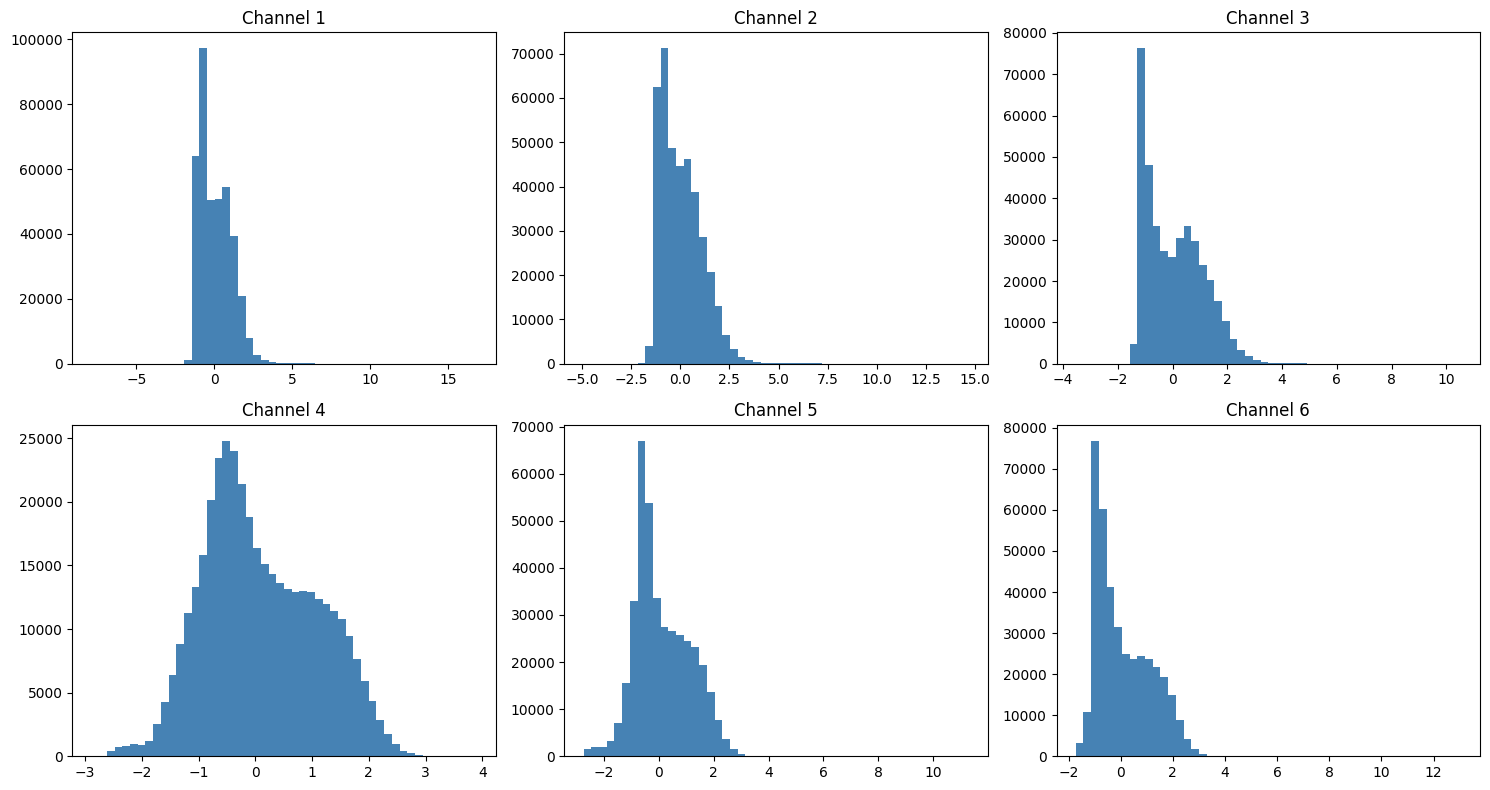

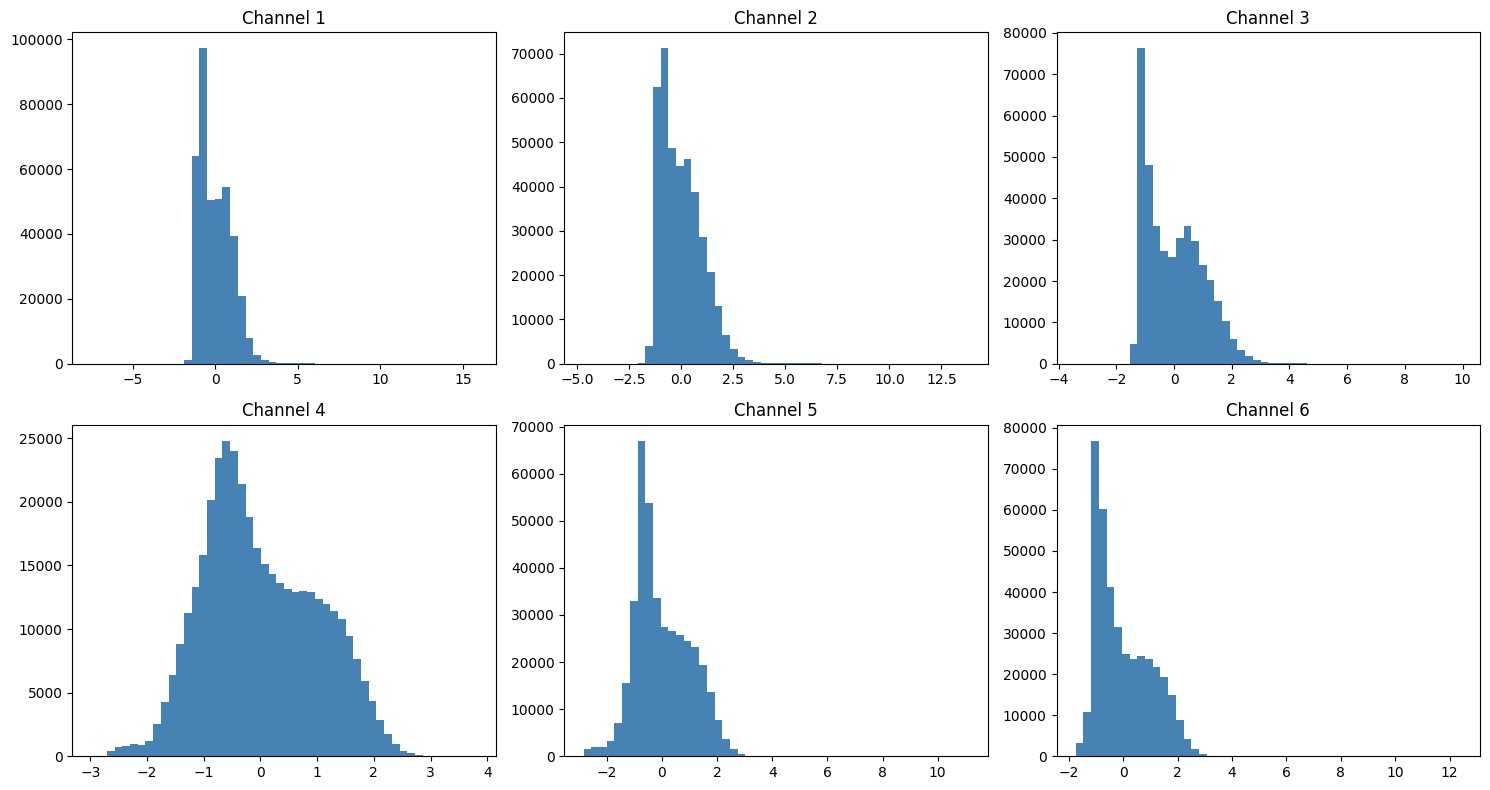



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5593      39.95%
1         1435      10.25%
2         6972      49.80%

Total samples: 14000


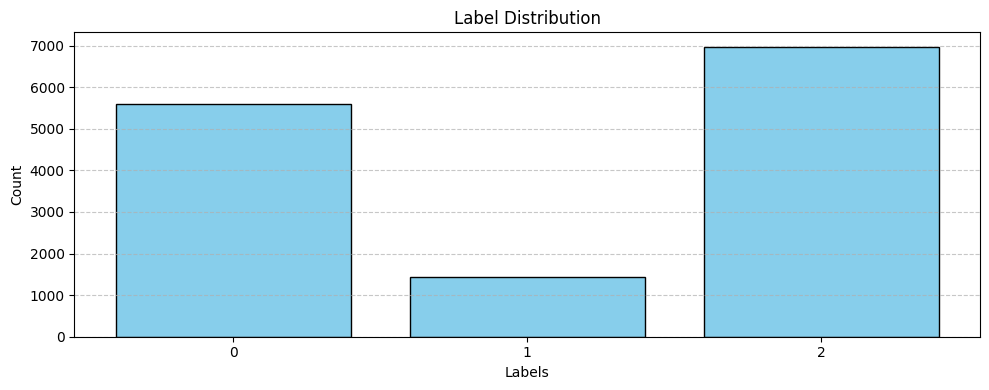


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


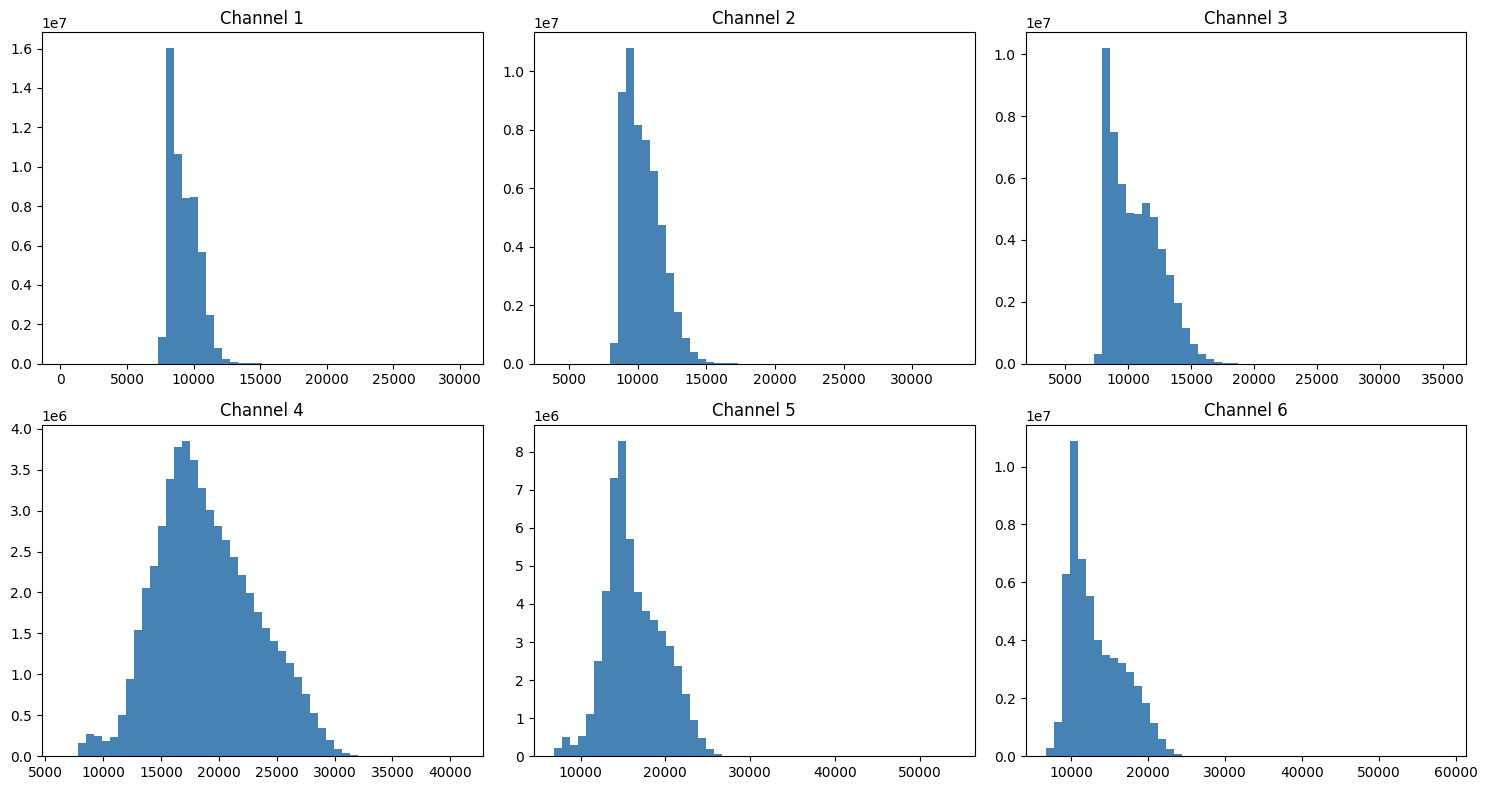

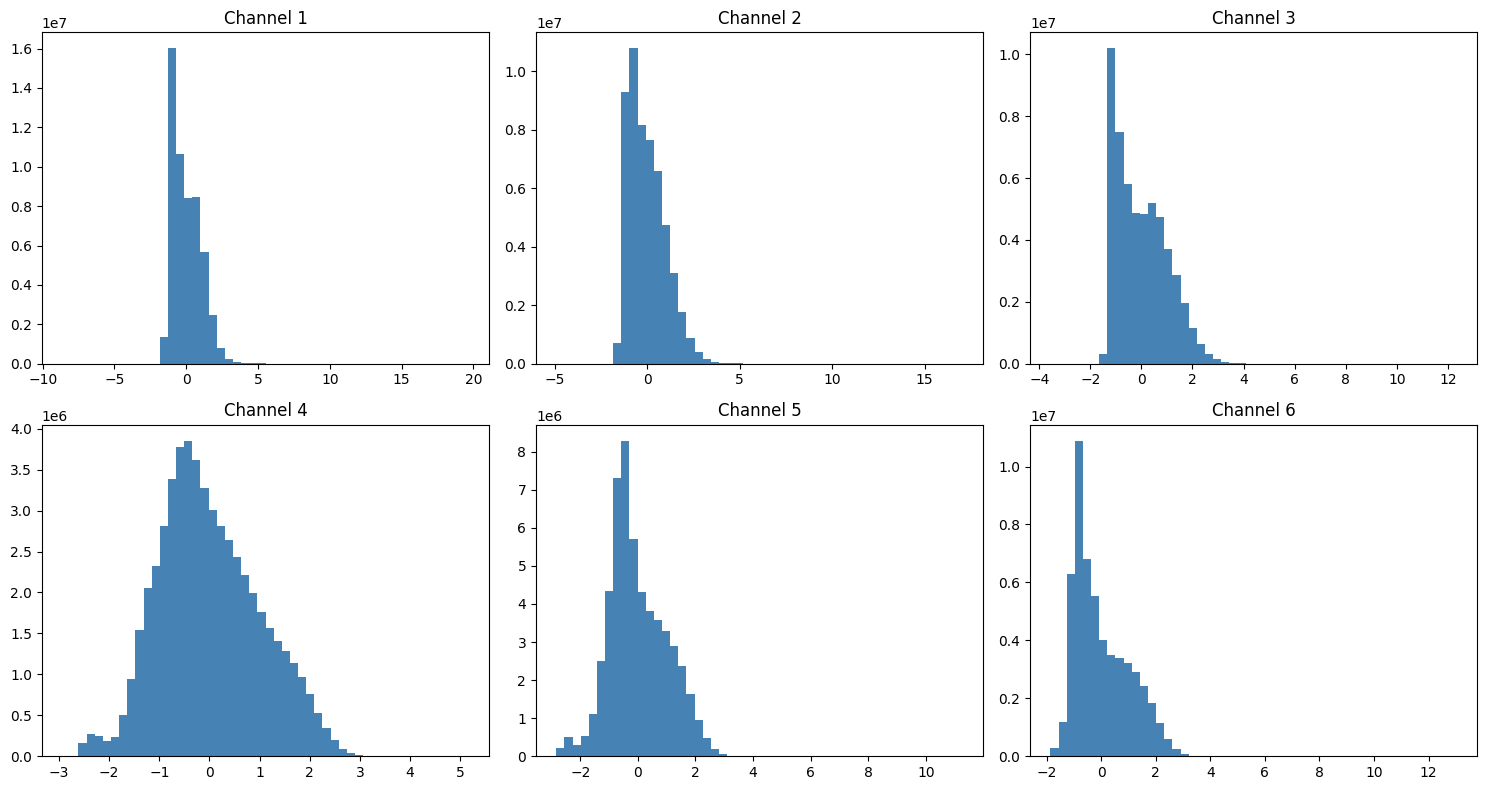



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


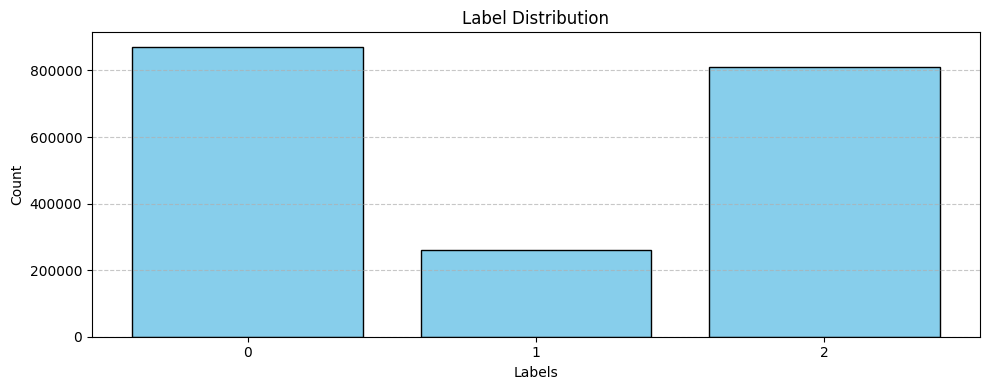

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.6067, 1.4474, 0.5124], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.60it/s]


Epoch [1/50] Train Loss: 0.8848, Train Acc: 0.6263 | Val Loss: 0.4362, Val Acc: 0.8365, F1: 0.8375, Kappa: 0.7351


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [2/50] Train Loss: 0.6542, Train Acc: 0.6927 | Val Loss: 0.3736, Val Acc: 0.8718, F1: 0.8713, Kappa: 0.7904


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.56it/s]


Epoch [3/50] Train Loss: 0.5939, Train Acc: 0.7264 | Val Loss: 0.4085, Val Acc: 0.8603, F1: 0.8634, Kappa: 0.7691


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.66it/s]


Epoch [4/50] Train Loss: 0.5666, Train Acc: 0.7441 | Val Loss: 0.3424, Val Acc: 0.8702, F1: 0.8658, Kappa: 0.7894


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [5/50] Train Loss: 0.5422, Train Acc: 0.7576 | Val Loss: 0.3698, Val Acc: 0.8511, F1: 0.8497, Kappa: 0.7591


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [6/50] Train Loss: 0.5299, Train Acc: 0.7604 | Val Loss: 0.3138, Val Acc: 0.8860, F1: 0.8862, Kappa: 0.8131


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.68it/s]


Epoch [7/50] Train Loss: 0.5100, Train Acc: 0.7744 | Val Loss: 0.3079, Val Acc: 0.8858, F1: 0.8842, Kappa: 0.8133


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [8/50] Train Loss: 0.4962, Train Acc: 0.7804 | Val Loss: 0.2861, Val Acc: 0.8912, F1: 0.8911, Kappa: 0.8217


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.49it/s]


Epoch [9/50] Train Loss: 0.4962, Train Acc: 0.7808 | Val Loss: 0.3097, Val Acc: 0.8828, F1: 0.8826, Kappa: 0.8083


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.59it/s]


Epoch [10/50] Train Loss: 0.4848, Train Acc: 0.7861 | Val Loss: 0.3220, Val Acc: 0.8715, F1: 0.8716, Kappa: 0.7904


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [11/50] Train Loss: 0.4694, Train Acc: 0.7939 | Val Loss: 0.3044, Val Acc: 0.8890, F1: 0.8900, Kappa: 0.8178


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [12/50] Train Loss: 0.4767, Train Acc: 0.7863 | Val Loss: 0.3219, Val Acc: 0.8835, F1: 0.8849, Kappa: 0.8092


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.65it/s]


Epoch [13/50] Train Loss: 0.4585, Train Acc: 0.7994 | Val Loss: 0.3231, Val Acc: 0.8876, F1: 0.8882, Kappa: 0.8160


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [14/50] Train Loss: 0.4607, Train Acc: 0.7989 | Val Loss: 0.3485, Val Acc: 0.8632, F1: 0.8735, Kappa: 0.7756


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.61it/s]


Epoch [15/50] Train Loss: 0.4199, Train Acc: 0.8174 | Val Loss: 0.2834, Val Acc: 0.8948, F1: 0.8941, Kappa: 0.8279


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.60it/s]


Epoch [16/50] Train Loss: 0.4130, Train Acc: 0.8230 | Val Loss: 0.2765, Val Acc: 0.8906, F1: 0.8870, Kappa: 0.8215


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [17/50] Train Loss: 0.4151, Train Acc: 0.8170 | Val Loss: 0.2713, Val Acc: 0.8982, F1: 0.8987, Kappa: 0.8331


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [18/50] Train Loss: 0.4040, Train Acc: 0.8233 | Val Loss: 0.2693, Val Acc: 0.8985, F1: 0.8986, Kappa: 0.8336


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.66it/s]


Epoch [19/50] Train Loss: 0.4150, Train Acc: 0.8236 | Val Loss: 0.2926, Val Acc: 0.8872, F1: 0.8877, Kappa: 0.8157


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [20/50] Train Loss: 0.3974, Train Acc: 0.8258 | Val Loss: 0.2775, Val Acc: 0.8991, F1: 0.9007, Kappa: 0.8343


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [21/50] Train Loss: 0.3896, Train Acc: 0.8309 | Val Loss: 0.2826, Val Acc: 0.8996, F1: 0.9027, Kappa: 0.8350


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.51it/s]


Epoch [22/50] Train Loss: 0.3993, Train Acc: 0.8236 | Val Loss: 0.2719, Val Acc: 0.8999, F1: 0.9023, Kappa: 0.8354


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.58it/s]


Epoch [23/50] Train Loss: 0.3922, Train Acc: 0.8313 | Val Loss: 0.3023, Val Acc: 0.8908, F1: 0.8922, Kappa: 0.8208


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [24/50] Train Loss: 0.3921, Train Acc: 0.8296 | Val Loss: 0.2855, Val Acc: 0.8930, F1: 0.8891, Kappa: 0.8257


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.64it/s]


Epoch [25/50] Train Loss: 0.3652, Train Acc: 0.8426 | Val Loss: 0.2722, Val Acc: 0.9030, F1: 0.9027, Kappa: 0.8409


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [26/50] Train Loss: 0.3577, Train Acc: 0.8478 | Val Loss: 0.2670, Val Acc: 0.9044, F1: 0.9055, Kappa: 0.8430


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.66it/s]


Epoch [27/50] Train Loss: 0.3478, Train Acc: 0.8488 | Val Loss: 0.2765, Val Acc: 0.9010, F1: 0.9006, Kappa: 0.8378


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [28/50] Train Loss: 0.3464, Train Acc: 0.8511 | Val Loss: 0.2695, Val Acc: 0.9030, F1: 0.9043, Kappa: 0.8406


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.68it/s]


Epoch [29/50] Train Loss: 0.3485, Train Acc: 0.8486 | Val Loss: 0.2694, Val Acc: 0.9062, F1: 0.9074, Kappa: 0.8458


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [30/50] Train Loss: 0.3391, Train Acc: 0.8540 | Val Loss: 0.2845, Val Acc: 0.8995, F1: 0.9020, Kappa: 0.8351


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.65it/s]


Epoch [31/50] Train Loss: 0.3385, Train Acc: 0.8524 | Val Loss: 0.2785, Val Acc: 0.9053, F1: 0.9068, Kappa: 0.8444


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.66it/s]


Epoch [32/50] Train Loss: 0.3444, Train Acc: 0.8521 | Val Loss: 0.2761, Val Acc: 0.8990, F1: 0.8983, Kappa: 0.8345


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [33/50] Train Loss: 0.3225, Train Acc: 0.8592 | Val Loss: 0.2744, Val Acc: 0.9036, F1: 0.9040, Kappa: 0.8419


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.62it/s]


Epoch [34/50] Train Loss: 0.3142, Train Acc: 0.8652 | Val Loss: 0.2760, Val Acc: 0.9046, F1: 0.9047, Kappa: 0.8435


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.50it/s]


Epoch [35/50] Train Loss: 0.3187, Train Acc: 0.8614 | Val Loss: 0.2736, Val Acc: 0.9051, F1: 0.9076, Kappa: 0.8440


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.62it/s]


Epoch [36/50] Train Loss: 0.3145, Train Acc: 0.8646 | Val Loss: 0.2809, Val Acc: 0.9039, F1: 0.9054, Kappa: 0.8421


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.63it/s]


Epoch [37/50] Train Loss: 0.3129, Train Acc: 0.8692 | Val Loss: 0.2758, Val Acc: 0.9013, F1: 0.9026, Kappa: 0.8380


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.60it/s]


Epoch [38/50] Train Loss: 0.3126, Train Acc: 0.8684 | Val Loss: 0.2749, Val Acc: 0.9054, F1: 0.9074, Kappa: 0.8446


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.55it/s]


Epoch [39/50] Train Loss: 0.3055, Train Acc: 0.8706 | Val Loss: 0.2782, Val Acc: 0.9053, F1: 0.9066, Kappa: 0.8445


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.58it/s]


Epoch [40/50] Train Loss: 0.2970, Train Acc: 0.8730 | Val Loss: 0.2809, Val Acc: 0.9088, F1: 0.9108, Kappa: 0.8500


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.56it/s]


Epoch [41/50] Train Loss: 0.3010, Train Acc: 0.8716 | Val Loss: 0.2791, Val Acc: 0.9063, F1: 0.9078, Kappa: 0.8459


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.65it/s]


Epoch [42/50] Train Loss: 0.2965, Train Acc: 0.8741 | Val Loss: 0.2856, Val Acc: 0.9055, F1: 0.9081, Kappa: 0.8446


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [43/50] Train Loss: 0.2947, Train Acc: 0.8731 | Val Loss: 0.2835, Val Acc: 0.9049, F1: 0.9072, Kappa: 0.8434


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.64it/s]


Epoch [44/50] Train Loss: 0.2942, Train Acc: 0.8730 | Val Loss: 0.2813, Val Acc: 0.9058, F1: 0.9071, Kappa: 0.8450


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.66it/s]


Epoch [45/50] Train Loss: 0.2918, Train Acc: 0.8735 | Val Loss: 0.2784, Val Acc: 0.9069, F1: 0.9094, Kappa: 0.8469


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.63it/s]


Epoch [46/50] Train Loss: 0.2955, Train Acc: 0.8724 | Val Loss: 0.2837, Val Acc: 0.9056, F1: 0.9080, Kappa: 0.8448


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.48it/s]


Epoch [47/50] Train Loss: 0.2924, Train Acc: 0.8728 | Val Loss: 0.2867, Val Acc: 0.9061, F1: 0.9074, Kappa: 0.8455


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.46it/s]


Epoch [48/50] Train Loss: 0.2880, Train Acc: 0.8749 | Val Loss: 0.2876, Val Acc: 0.9081, F1: 0.9101, Kappa: 0.8490


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.60it/s]


Epoch [49/50] Train Loss: 0.2875, Train Acc: 0.8772 | Val Loss: 0.2848, Val Acc: 0.9075, F1: 0.9103, Kappa: 0.8477


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [50/50] Train Loss: 0.2867, Train Acc: 0.8763 | Val Loss: 0.2817, Val Acc: 0.9074, F1: 0.9098, Kappa: 0.8477


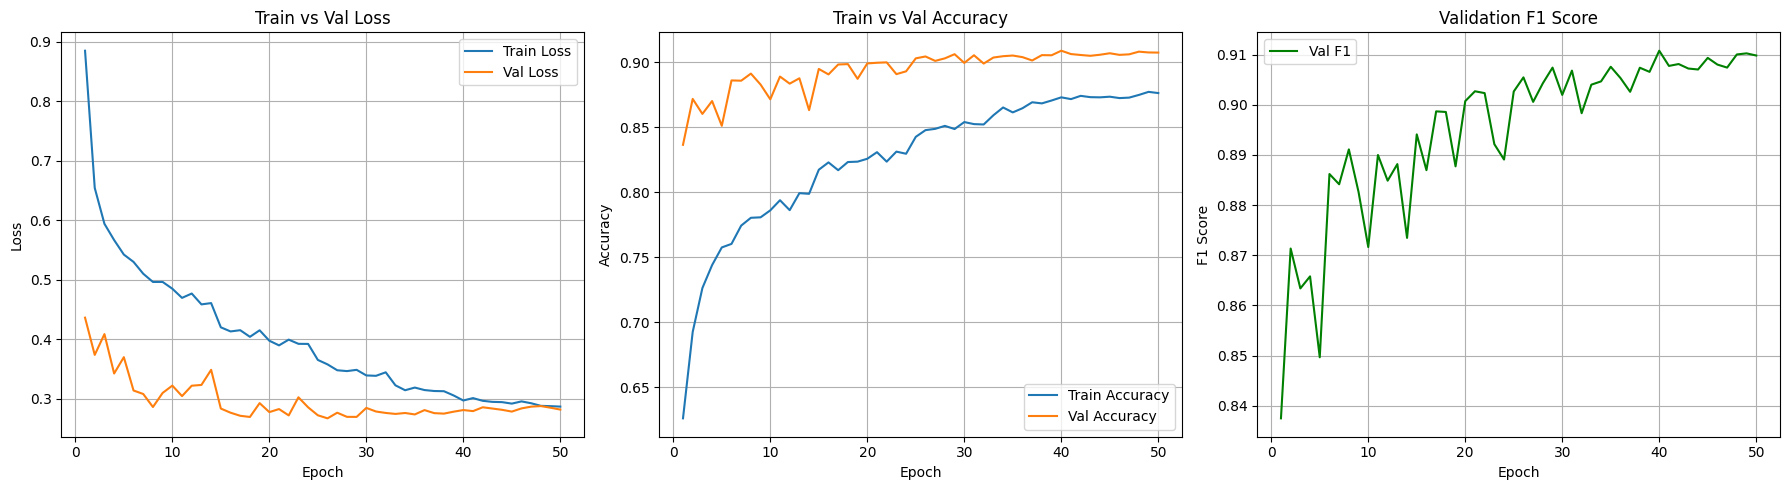


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:41<00:00, 39.69it/s]



====== Test Results ======
Overall Loss: 0.2818
Overall Accuracy: 0.9066
Cohen's Kappa: 0.8461
Per Class F1: [0.9060912  0.91762952 0.90351805]
Macro (Avg) F1: 0.9091


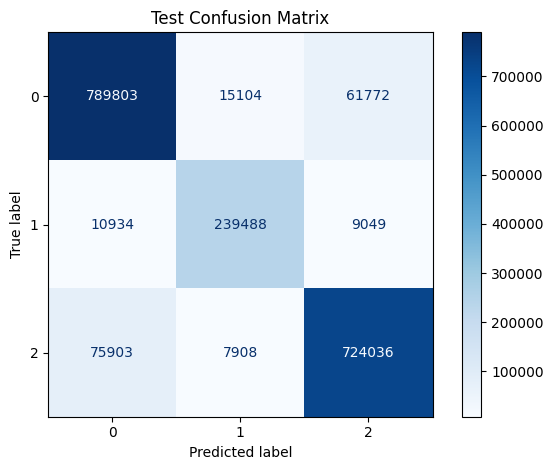

History Dumped in file /kaggle/working/true_BCNN_data_bald_history.json_history.json


====== Loading Data /kaggle/input/data-al/true_BCNN_data_bvsb.npz ======
Train Data:  (14000, 28, 6) (14000,)


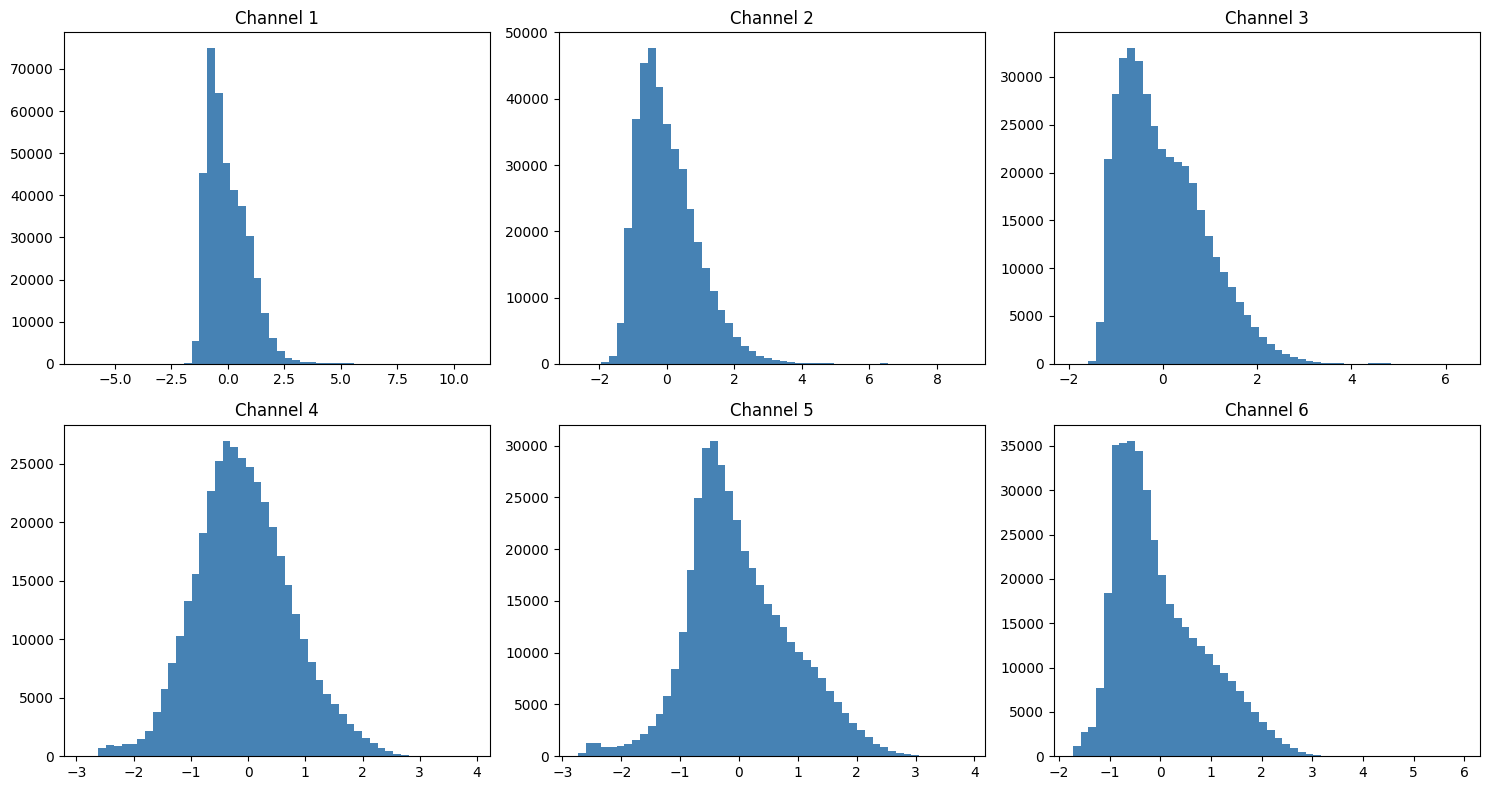

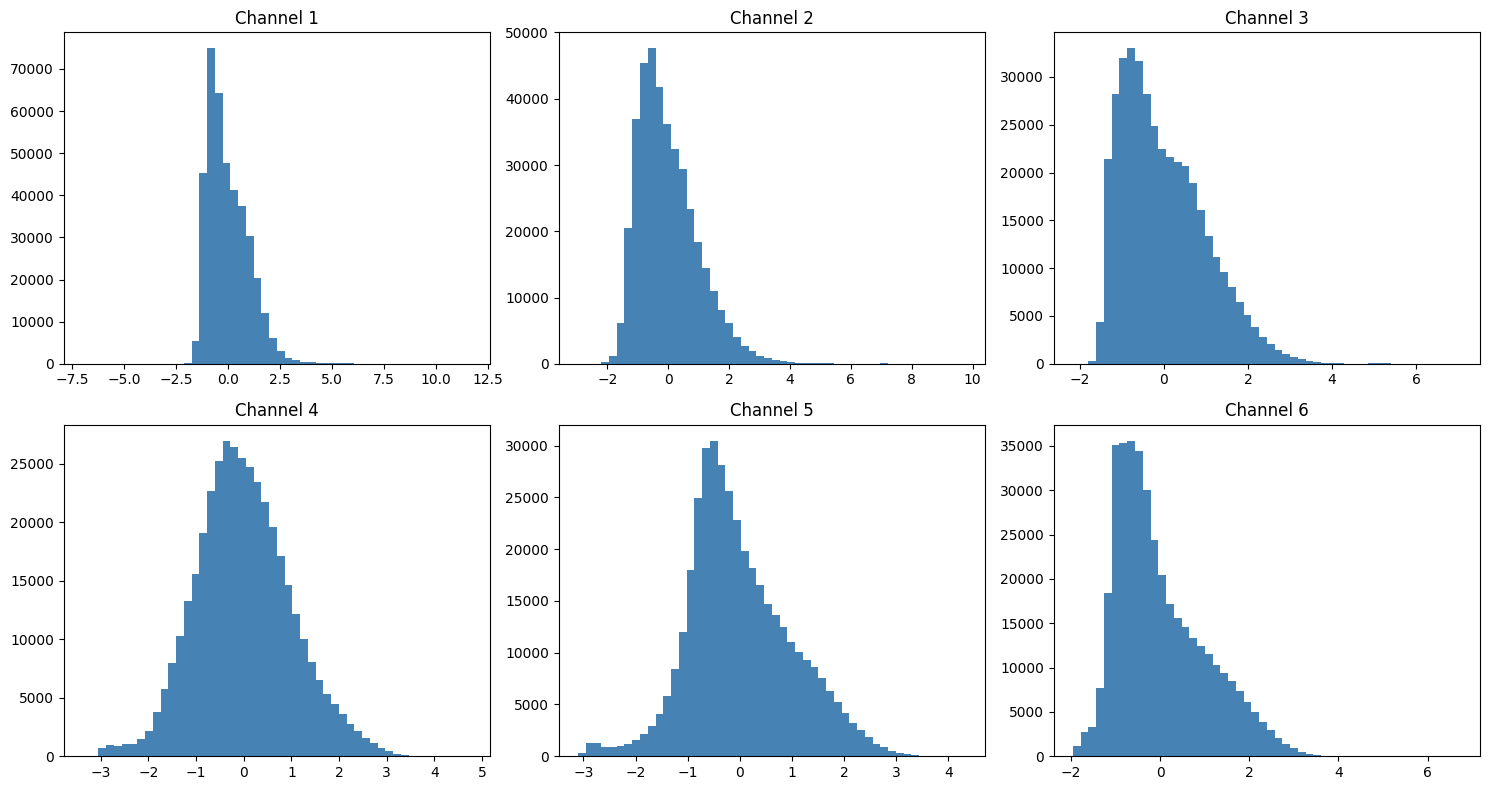



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6262      44.73%
1         1620      11.57%
2         6118      43.70%

Total samples: 14000


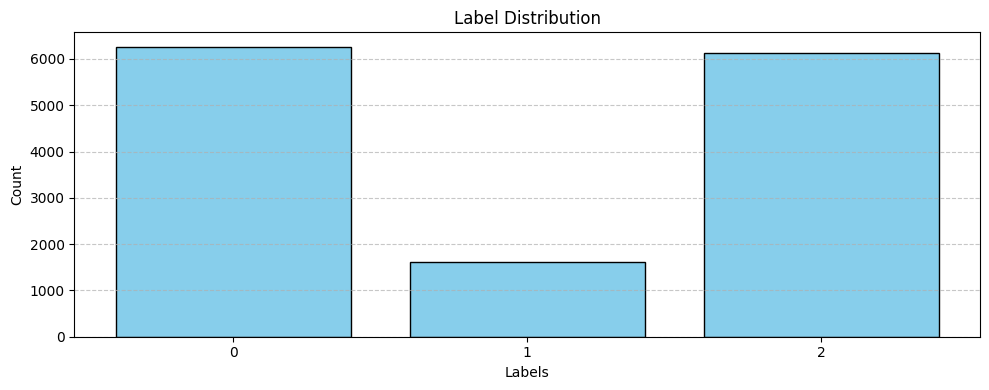


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


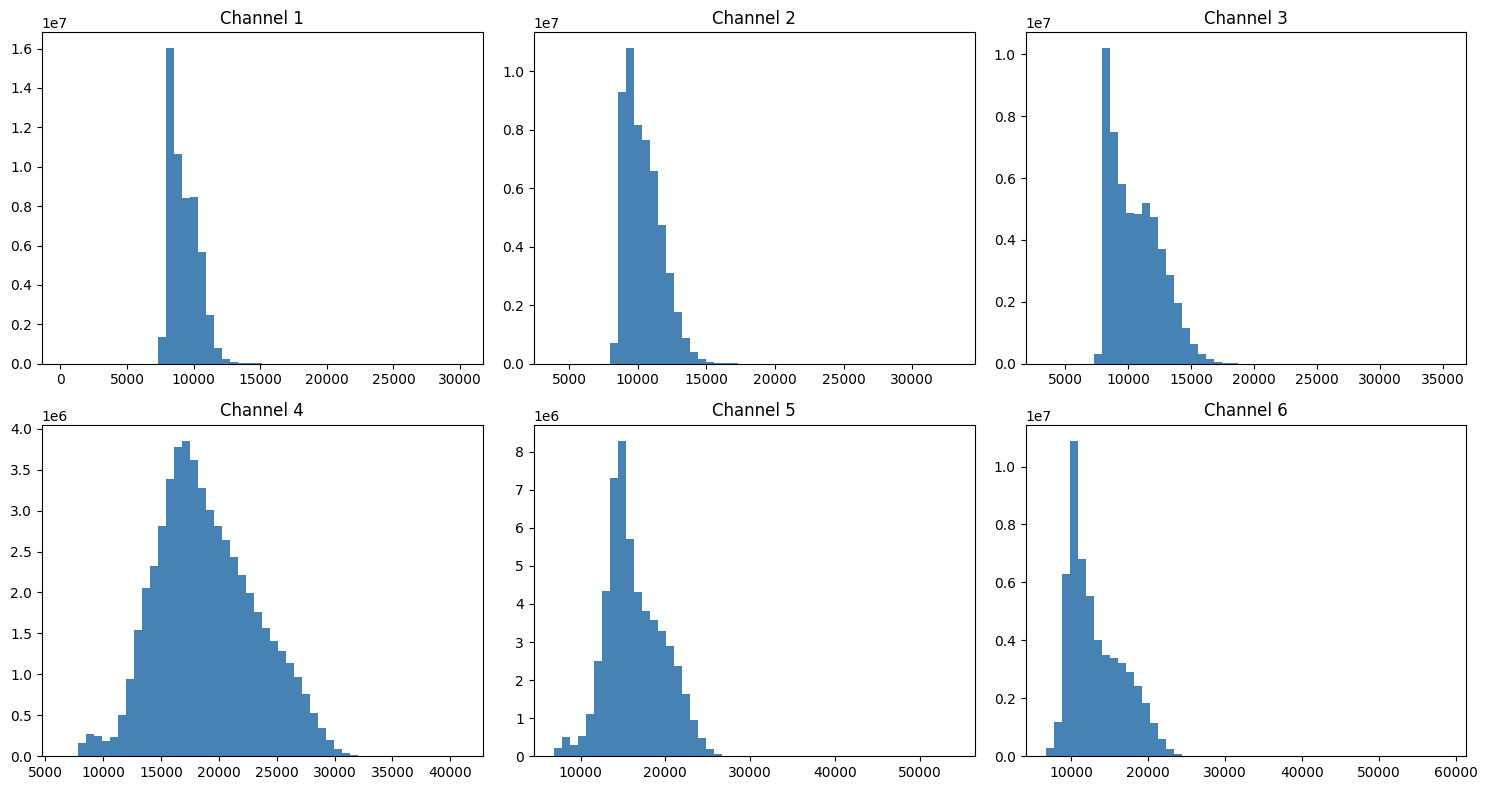

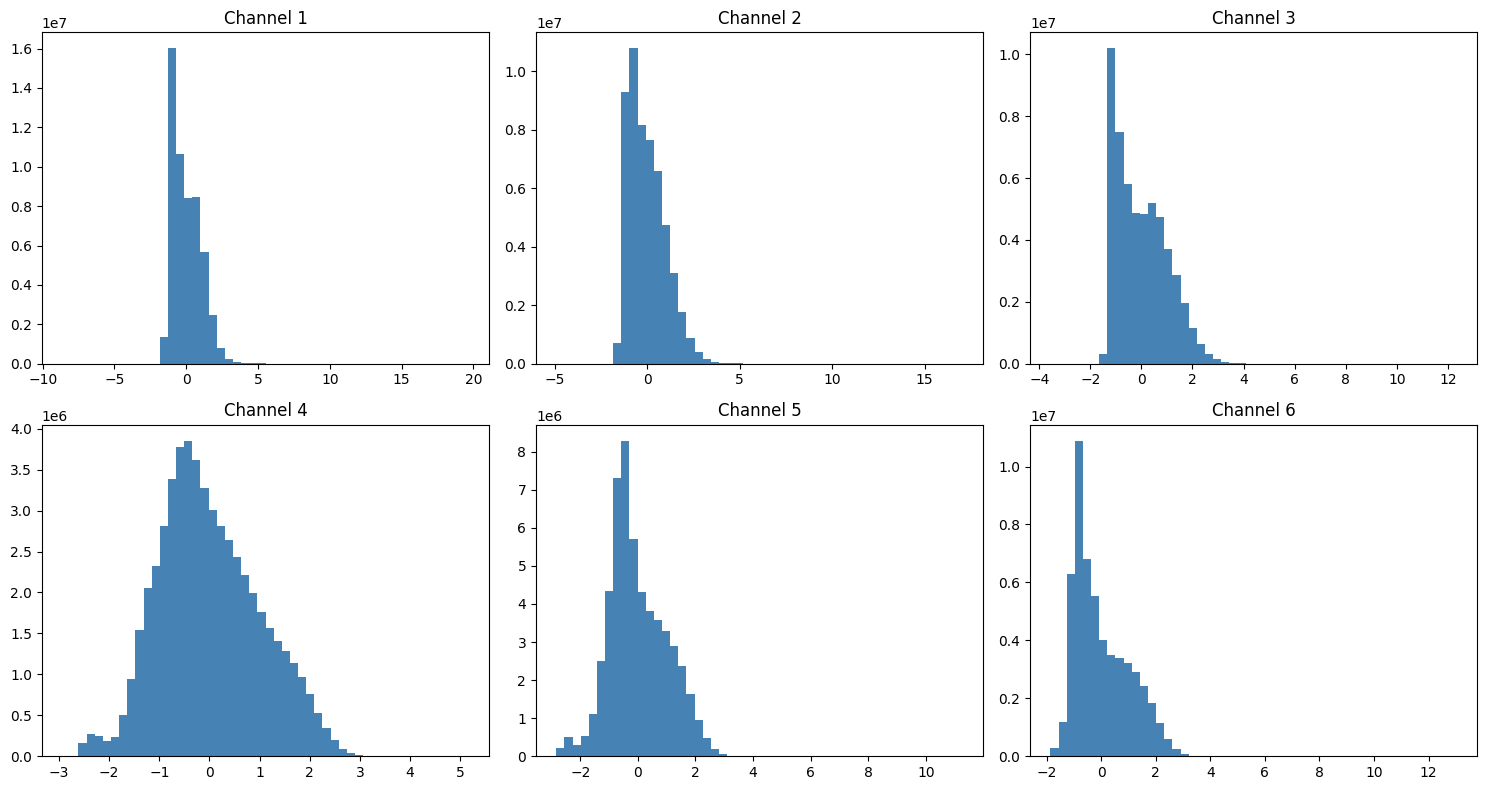



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


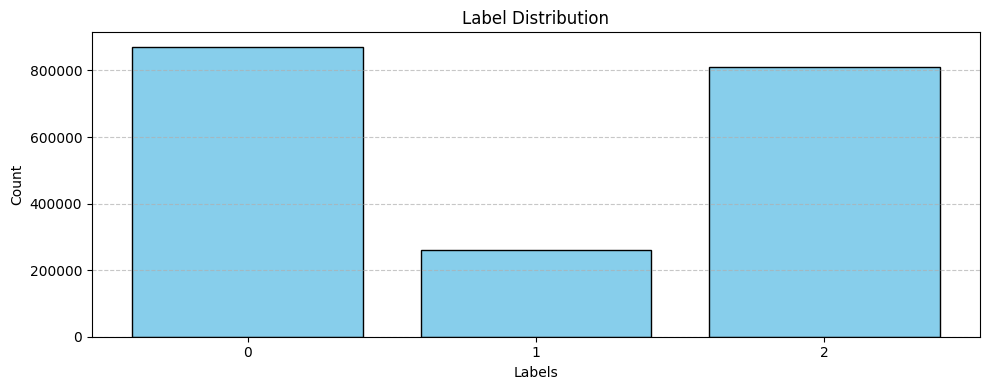

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5569, 1.3560, 0.5669], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [1/50] Train Loss: 1.0322, Train Acc: 0.5304 | Val Loss: 0.5956, Val Acc: 0.7120, F1: 0.7172, Kappa: 0.5285


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [2/50] Train Loss: 0.8239, Train Acc: 0.5726 | Val Loss: 0.5282, Val Acc: 0.8244, F1: 0.8320, Kappa: 0.7114


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [3/50] Train Loss: 0.7938, Train Acc: 0.5896 | Val Loss: 0.5058, Val Acc: 0.8164, F1: 0.8288, Kappa: 0.6982


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [4/50] Train Loss: 0.7776, Train Acc: 0.5933 | Val Loss: 0.4431, Val Acc: 0.8358, F1: 0.8429, Kappa: 0.7331


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [5/50] Train Loss: 0.7577, Train Acc: 0.6119 | Val Loss: 0.3996, Val Acc: 0.8451, F1: 0.8495, Kappa: 0.7487


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [6/50] Train Loss: 0.7541, Train Acc: 0.6094 | Val Loss: 0.4271, Val Acc: 0.8667, F1: 0.8646, Kappa: 0.7830


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [7/50] Train Loss: 0.7462, Train Acc: 0.6102 | Val Loss: 0.4822, Val Acc: 0.7724, F1: 0.7849, Kappa: 0.6277


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [8/50] Train Loss: 0.7350, Train Acc: 0.6207 | Val Loss: 0.3755, Val Acc: 0.8776, F1: 0.8768, Kappa: 0.7999


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [9/50] Train Loss: 0.7294, Train Acc: 0.6203 | Val Loss: 0.3988, Val Acc: 0.8702, F1: 0.8726, Kappa: 0.7873


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [10/50] Train Loss: 0.7169, Train Acc: 0.6243 | Val Loss: 0.3972, Val Acc: 0.8733, F1: 0.8770, Kappa: 0.7924


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [11/50] Train Loss: 0.7171, Train Acc: 0.6299 | Val Loss: 0.4054, Val Acc: 0.8631, F1: 0.8657, Kappa: 0.7764


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [12/50] Train Loss: 0.7129, Train Acc: 0.6260 | Val Loss: 0.3825, Val Acc: 0.8648, F1: 0.8641, Kappa: 0.7798


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [13/50] Train Loss: 0.7068, Train Acc: 0.6311 | Val Loss: 0.4173, Val Acc: 0.8849, F1: 0.8872, Kappa: 0.8106


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.95it/s]


Epoch [14/50] Train Loss: 0.7130, Train Acc: 0.6357 | Val Loss: 0.3510, Val Acc: 0.8893, F1: 0.8879, Kappa: 0.8188


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [15/50] Train Loss: 0.6945, Train Acc: 0.6361 | Val Loss: 0.3811, Val Acc: 0.8845, F1: 0.8846, Kappa: 0.8100


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [16/50] Train Loss: 0.7008, Train Acc: 0.6394 | Val Loss: 0.3897, Val Acc: 0.8747, F1: 0.8710, Kappa: 0.7959


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [17/50] Train Loss: 0.6930, Train Acc: 0.6434 | Val Loss: 0.3607, Val Acc: 0.8858, F1: 0.8829, Kappa: 0.8137


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [18/50] Train Loss: 0.6894, Train Acc: 0.6477 | Val Loss: 0.3465, Val Acc: 0.8803, F1: 0.8781, Kappa: 0.8051


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [19/50] Train Loss: 0.6880, Train Acc: 0.6417 | Val Loss: 0.3275, Val Acc: 0.8823, F1: 0.8776, Kappa: 0.8087


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [20/50] Train Loss: 0.6790, Train Acc: 0.6529 | Val Loss: 0.3494, Val Acc: 0.8837, F1: 0.8843, Kappa: 0.8099


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [21/50] Train Loss: 0.6766, Train Acc: 0.6484 | Val Loss: 0.3383, Val Acc: 0.8998, F1: 0.9012, Kappa: 0.8349


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [22/50] Train Loss: 0.6721, Train Acc: 0.6549 | Val Loss: 0.3905, Val Acc: 0.8731, F1: 0.8771, Kappa: 0.7914


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [23/50] Train Loss: 0.6688, Train Acc: 0.6572 | Val Loss: 0.3153, Val Acc: 0.8931, F1: 0.8916, Kappa: 0.8250


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [24/50] Train Loss: 0.6608, Train Acc: 0.6646 | Val Loss: 0.3570, Val Acc: 0.8838, F1: 0.8858, Kappa: 0.8097


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [25/50] Train Loss: 0.6615, Train Acc: 0.6595 | Val Loss: 0.3159, Val Acc: 0.8885, F1: 0.8858, Kappa: 0.8182


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [26/50] Train Loss: 0.6594, Train Acc: 0.6629 | Val Loss: 0.3571, Val Acc: 0.8637, F1: 0.8674, Kappa: 0.7778


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [27/50] Train Loss: 0.6573, Train Acc: 0.6633 | Val Loss: 0.3831, Val Acc: 0.8437, F1: 0.8504, Kappa: 0.7436


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [28/50] Train Loss: 0.6468, Train Acc: 0.6721 | Val Loss: 0.3159, Val Acc: 0.8980, F1: 0.8984, Kappa: 0.8326


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [29/50] Train Loss: 0.6459, Train Acc: 0.6776 | Val Loss: 0.3258, Val Acc: 0.8944, F1: 0.8935, Kappa: 0.8272


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [30/50] Train Loss: 0.6238, Train Acc: 0.6829 | Val Loss: 0.3212, Val Acc: 0.8957, F1: 0.8972, Kappa: 0.8287


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [31/50] Train Loss: 0.6109, Train Acc: 0.6857 | Val Loss: 0.2974, Val Acc: 0.8968, F1: 0.8975, Kappa: 0.8308


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [32/50] Train Loss: 0.6116, Train Acc: 0.6857 | Val Loss: 0.3163, Val Acc: 0.8910, F1: 0.8885, Kappa: 0.8220


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [33/50] Train Loss: 0.6055, Train Acc: 0.6907 | Val Loss: 0.3075, Val Acc: 0.9014, F1: 0.9017, Kappa: 0.8379


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [34/50] Train Loss: 0.5961, Train Acc: 0.6950 | Val Loss: 0.2822, Val Acc: 0.8942, F1: 0.8910, Kappa: 0.8274


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [35/50] Train Loss: 0.5941, Train Acc: 0.6983 | Val Loss: 0.3017, Val Acc: 0.8968, F1: 0.8949, Kappa: 0.8310


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [36/50] Train Loss: 0.5996, Train Acc: 0.6937 | Val Loss: 0.3102, Val Acc: 0.9008, F1: 0.9010, Kappa: 0.8372


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [37/50] Train Loss: 0.5885, Train Acc: 0.7024 | Val Loss: 0.2858, Val Acc: 0.8980, F1: 0.8944, Kappa: 0.8336


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [38/50] Train Loss: 0.5853, Train Acc: 0.7041 | Val Loss: 0.3177, Val Acc: 0.8992, F1: 0.8984, Kappa: 0.8346


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [39/50] Train Loss: 0.5820, Train Acc: 0.7045 | Val Loss: 0.2917, Val Acc: 0.9006, F1: 0.8996, Kappa: 0.8372


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [40/50] Train Loss: 0.5759, Train Acc: 0.7122 | Val Loss: 0.3110, Val Acc: 0.9006, F1: 0.9007, Kappa: 0.8365


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [41/50] Train Loss: 0.5617, Train Acc: 0.7146 | Val Loss: 0.2925, Val Acc: 0.9039, F1: 0.9036, Kappa: 0.8422


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [42/50] Train Loss: 0.5551, Train Acc: 0.7226 | Val Loss: 0.3008, Val Acc: 0.9017, F1: 0.9034, Kappa: 0.8384


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [43/50] Train Loss: 0.5498, Train Acc: 0.7285 | Val Loss: 0.3004, Val Acc: 0.9065, F1: 0.9062, Kappa: 0.8461


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [44/50] Train Loss: 0.5462, Train Acc: 0.7242 | Val Loss: 0.2958, Val Acc: 0.9034, F1: 0.9025, Kappa: 0.8414


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [45/50] Train Loss: 0.5480, Train Acc: 0.7319 | Val Loss: 0.2826, Val Acc: 0.9047, F1: 0.9046, Kappa: 0.8439


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [46/50] Train Loss: 0.5468, Train Acc: 0.7296 | Val Loss: 0.2912, Val Acc: 0.9087, F1: 0.9085, Kappa: 0.8502


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [47/50] Train Loss: 0.5226, Train Acc: 0.7382 | Val Loss: 0.2909, Val Acc: 0.9055, F1: 0.9041, Kappa: 0.8451


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [48/50] Train Loss: 0.5202, Train Acc: 0.7362 | Val Loss: 0.2911, Val Acc: 0.9049, F1: 0.9046, Kappa: 0.8441


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [49/50] Train Loss: 0.5210, Train Acc: 0.7368 | Val Loss: 0.2944, Val Acc: 0.9062, F1: 0.9054, Kappa: 0.8458


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [50/50] Train Loss: 0.5160, Train Acc: 0.7422 | Val Loss: 0.3005, Val Acc: 0.9034, F1: 0.9038, Kappa: 0.8412


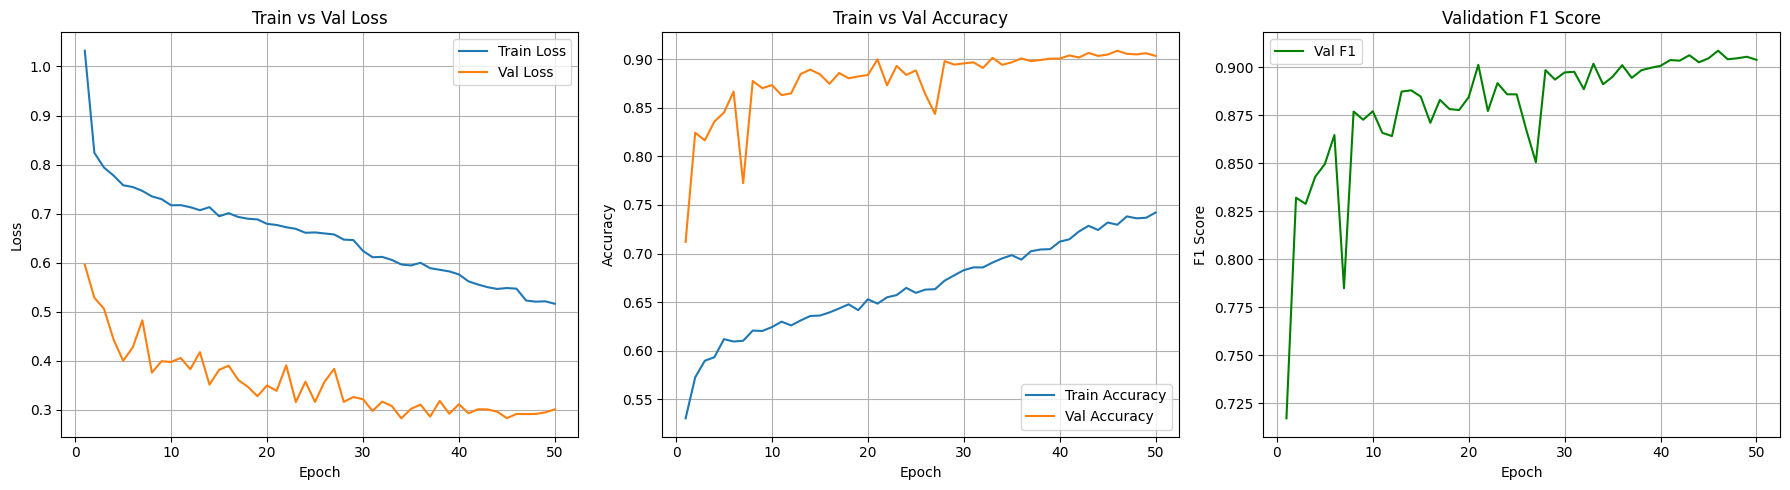


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:41<00:00, 39.67it/s]



====== Test Results ======
Overall Loss: 0.2975
Overall Accuracy: 0.9048
Cohen's Kappa: 0.8434
Per Class F1: [0.90639187 0.91074271 0.90117228]
Macro (Avg) F1: 0.9061


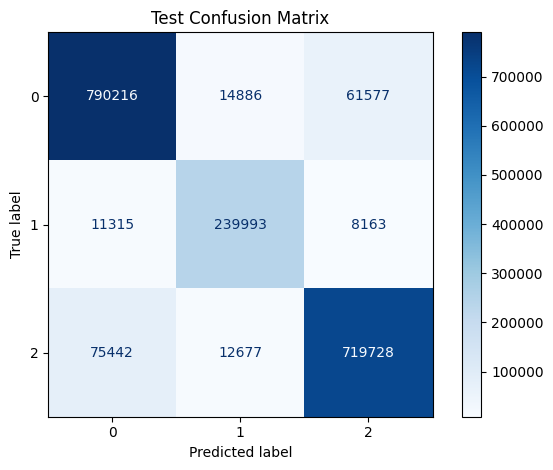

History Dumped in file /kaggle/working/true_BCNN_data_bvsb_history.json_history.json


====== Loading Data /kaggle/input/data-al/true_BCNN_data_predictive_entropy.npz ======
Train Data:  (14000, 28, 6) (14000,)


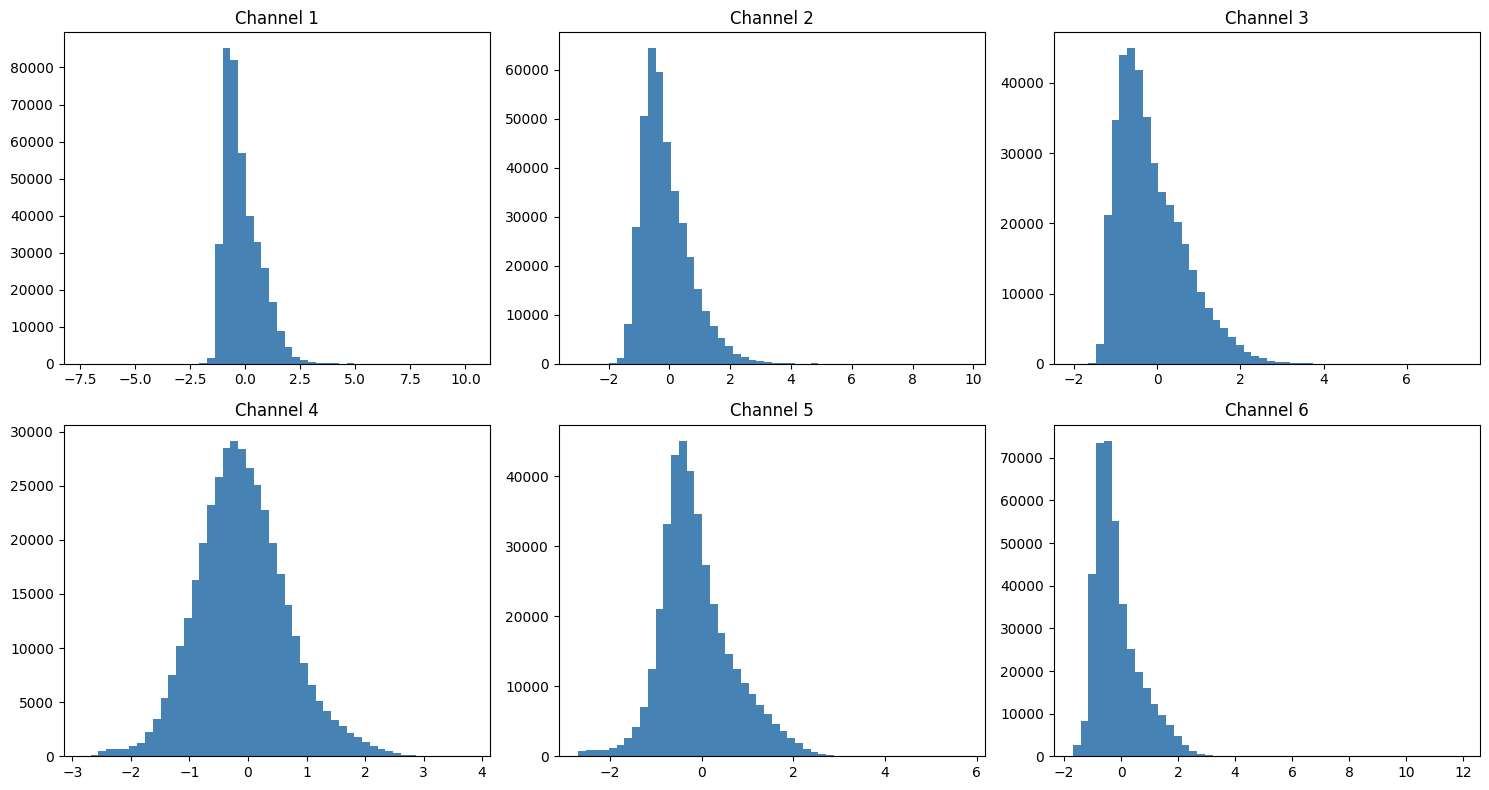

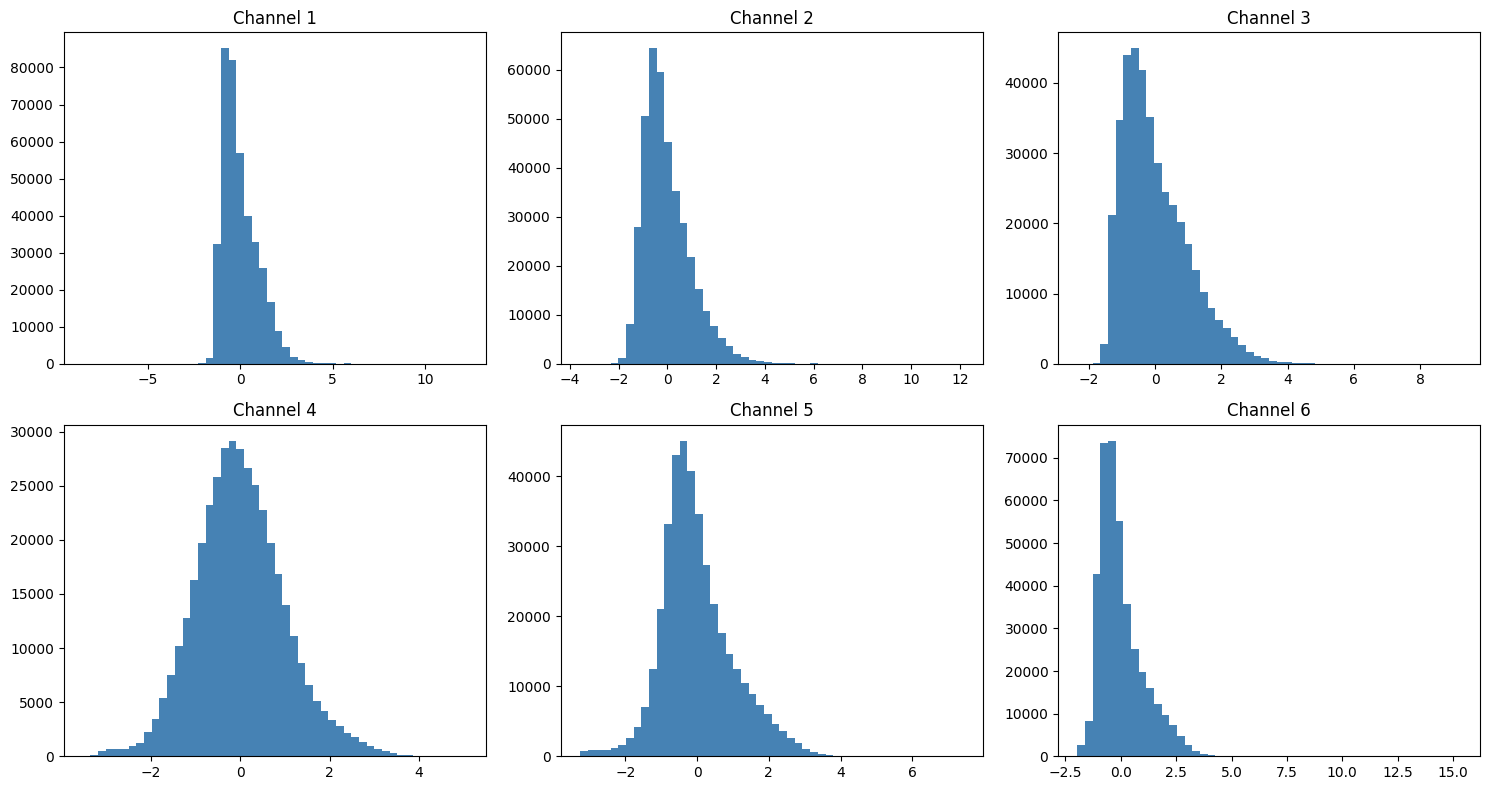



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5702      40.73%
1         2487      17.76%
2         5811      41.51%

Total samples: 14000


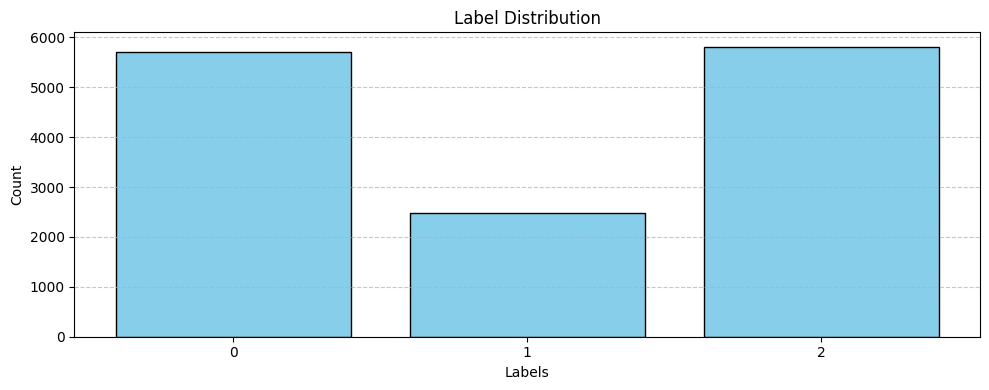


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


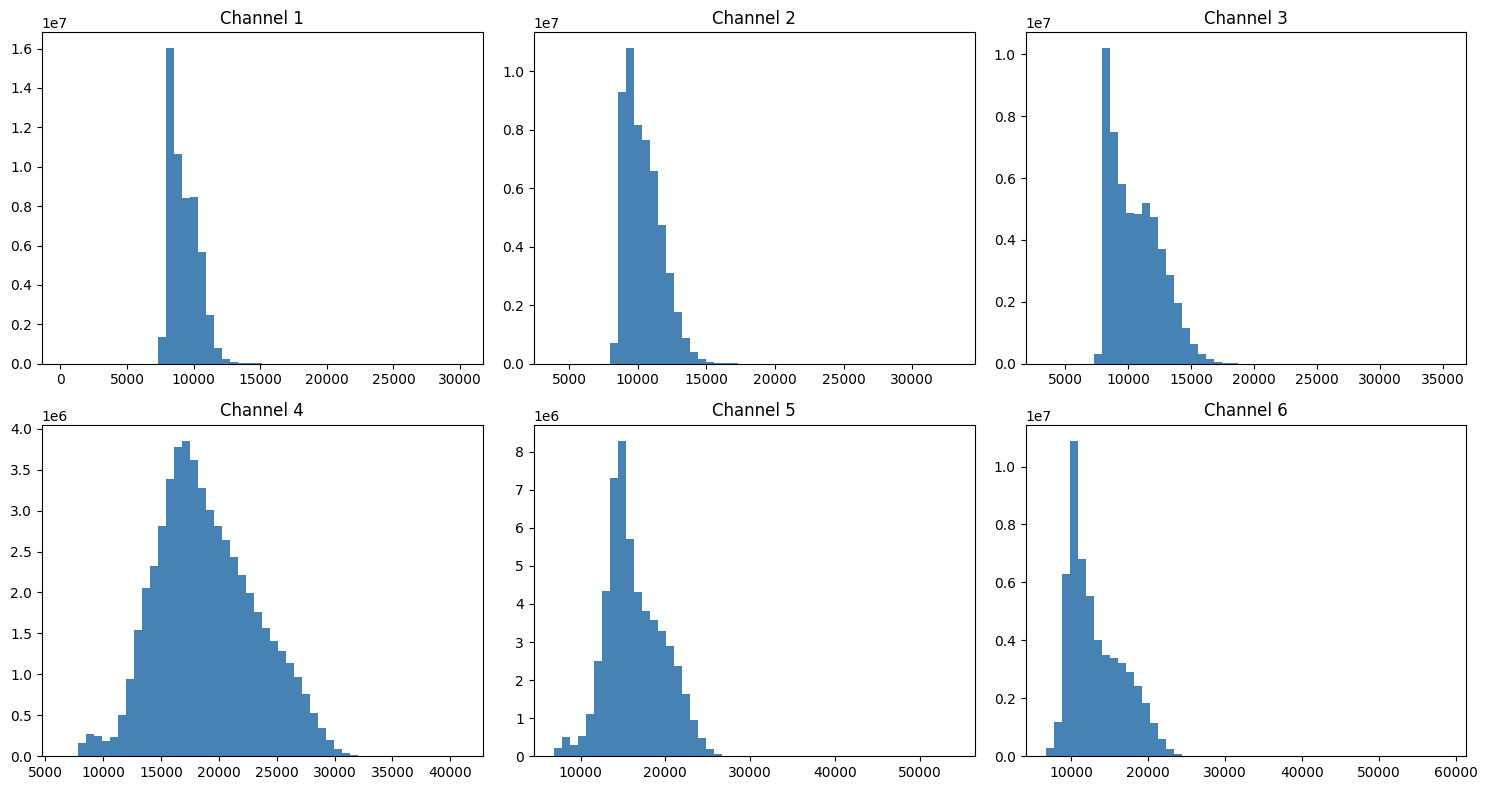

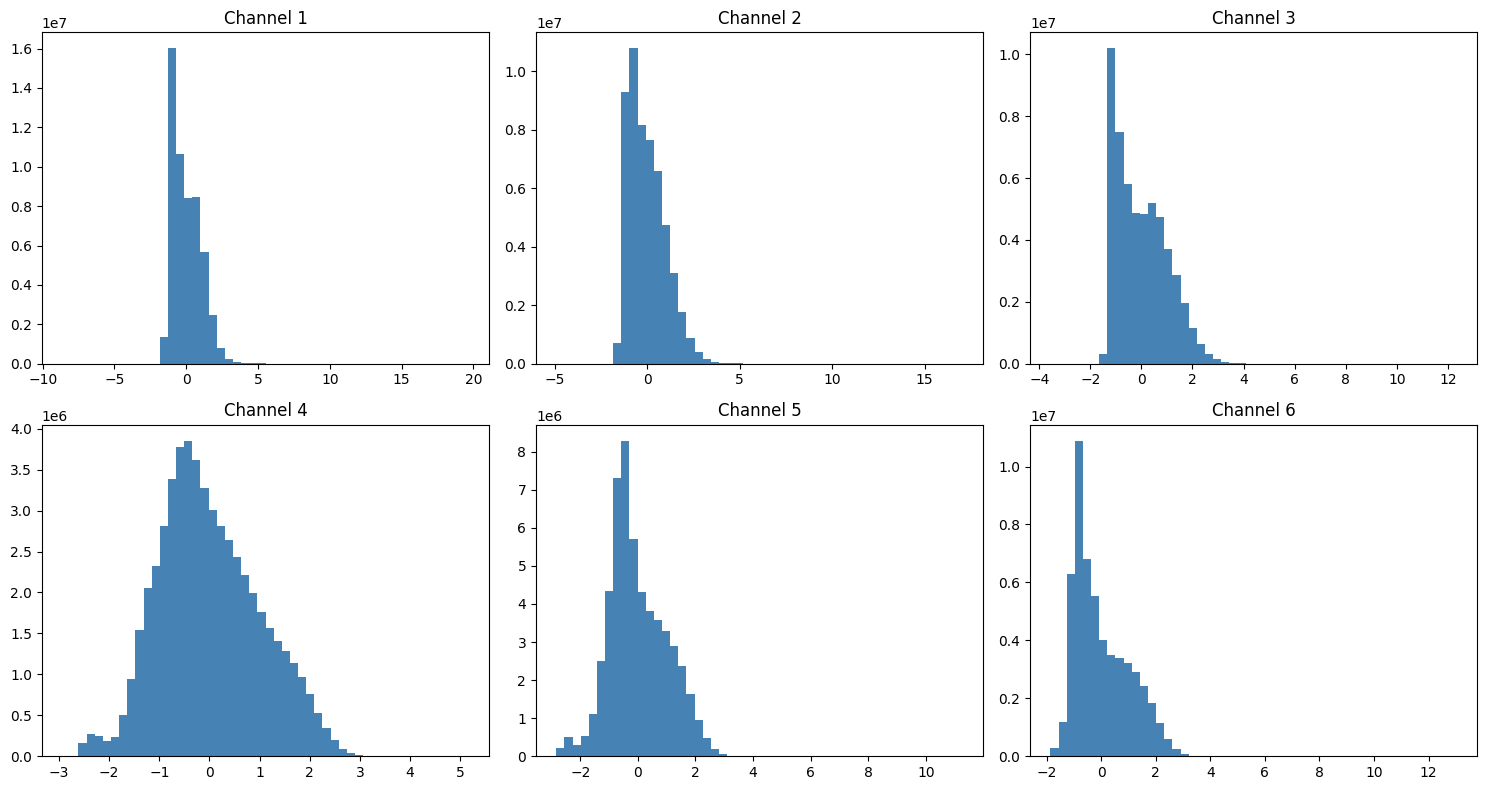



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


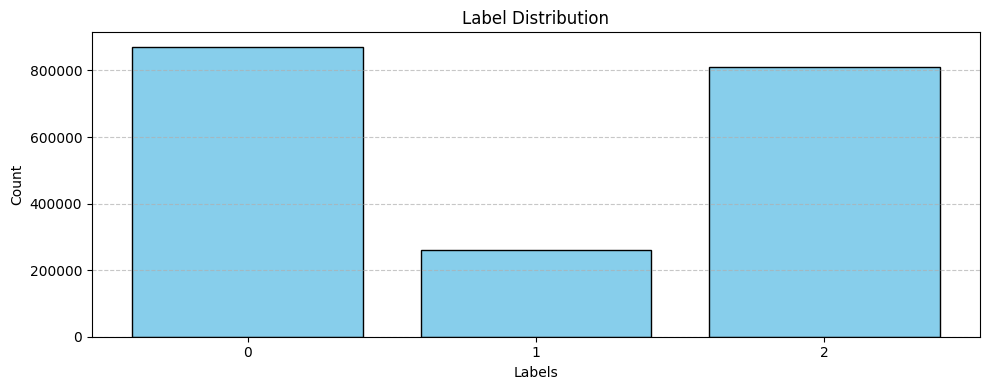

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5980, 1.0565, 0.5895], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [1/50] Train Loss: 1.2128, Train Acc: 0.4873 | Val Loss: 0.6186, Val Acc: 0.7380, F1: 0.7613, Kappa: 0.5752


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [2/50] Train Loss: 0.9539, Train Acc: 0.5404 | Val Loss: 0.5279, Val Acc: 0.8389, F1: 0.8448, Kappa: 0.7363


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [3/50] Train Loss: 0.9082, Train Acc: 0.5602 | Val Loss: 0.5124, Val Acc: 0.8254, F1: 0.8263, Kappa: 0.7184


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [4/50] Train Loss: 0.8868, Train Acc: 0.5701 | Val Loss: 0.4490, Val Acc: 0.8614, F1: 0.8596, Kappa: 0.7746


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [5/50] Train Loss: 0.8745, Train Acc: 0.5757 | Val Loss: 0.6178, Val Acc: 0.7156, F1: 0.7375, Kappa: 0.5411


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [6/50] Train Loss: 0.8658, Train Acc: 0.5806 | Val Loss: 0.4167, Val Acc: 0.8677, F1: 0.8672, Kappa: 0.7836


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [7/50] Train Loss: 0.8493, Train Acc: 0.5891 | Val Loss: 0.4175, Val Acc: 0.8578, F1: 0.8645, Kappa: 0.7671


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [8/50] Train Loss: 0.8400, Train Acc: 0.5956 | Val Loss: 0.4316, Val Acc: 0.8516, F1: 0.8543, Kappa: 0.7587


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [9/50] Train Loss: 0.8384, Train Acc: 0.5967 | Val Loss: 0.4170, Val Acc: 0.8639, F1: 0.8638, Kappa: 0.7786


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [10/50] Train Loss: 0.8337, Train Acc: 0.5983 | Val Loss: 0.4081, Val Acc: 0.8637, F1: 0.8628, Kappa: 0.7785


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [11/50] Train Loss: 0.8218, Train Acc: 0.6023 | Val Loss: 0.3862, Val Acc: 0.8675, F1: 0.8677, Kappa: 0.7839


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [12/50] Train Loss: 0.8283, Train Acc: 0.5976 | Val Loss: 0.4317, Val Acc: 0.8492, F1: 0.8459, Kappa: 0.7557


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [13/50] Train Loss: 0.8175, Train Acc: 0.6071 | Val Loss: 0.3801, Val Acc: 0.8693, F1: 0.8742, Kappa: 0.7853


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [14/50] Train Loss: 0.8082, Train Acc: 0.6136 | Val Loss: 0.4331, Val Acc: 0.8406, F1: 0.8461, Kappa: 0.7399


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [15/50] Train Loss: 0.8151, Train Acc: 0.6134 | Val Loss: 0.3993, Val Acc: 0.8608, F1: 0.8558, Kappa: 0.7752


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [16/50] Train Loss: 0.8093, Train Acc: 0.6141 | Val Loss: 0.3416, Val Acc: 0.8841, F1: 0.8855, Kappa: 0.8101


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [17/50] Train Loss: 0.8003, Train Acc: 0.6162 | Val Loss: 0.3951, Val Acc: 0.8632, F1: 0.8681, Kappa: 0.7750


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [18/50] Train Loss: 0.8024, Train Acc: 0.6135 | Val Loss: 0.4633, Val Acc: 0.8278, F1: 0.8356, Kappa: 0.7171


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [19/50] Train Loss: 0.8019, Train Acc: 0.6224 | Val Loss: 0.3929, Val Acc: 0.8618, F1: 0.8656, Kappa: 0.7743


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [20/50] Train Loss: 0.7933, Train Acc: 0.6196 | Val Loss: 0.3795, Val Acc: 0.8765, F1: 0.8797, Kappa: 0.7967


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [21/50] Train Loss: 0.7932, Train Acc: 0.6224 | Val Loss: 0.3678, Val Acc: 0.8688, F1: 0.8716, Kappa: 0.7855


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [22/50] Train Loss: 0.7859, Train Acc: 0.6306 | Val Loss: 0.3356, Val Acc: 0.8760, F1: 0.8769, Kappa: 0.7973


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [23/50] Train Loss: 0.7791, Train Acc: 0.6294 | Val Loss: 0.3814, Val Acc: 0.8693, F1: 0.8714, Kappa: 0.7860


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [24/50] Train Loss: 0.7830, Train Acc: 0.6316 | Val Loss: 0.4348, Val Acc: 0.8222, F1: 0.8332, Kappa: 0.7082


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [25/50] Train Loss: 0.7805, Train Acc: 0.6264 | Val Loss: 0.3401, Val Acc: 0.8783, F1: 0.8790, Kappa: 0.8011


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [26/50] Train Loss: 0.7743, Train Acc: 0.6268 | Val Loss: 0.3421, Val Acc: 0.8810, F1: 0.8837, Kappa: 0.8044


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [27/50] Train Loss: 0.7684, Train Acc: 0.6402 | Val Loss: 0.3410, Val Acc: 0.8809, F1: 0.8789, Kappa: 0.8059


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [28/50] Train Loss: 0.7723, Train Acc: 0.6338 | Val Loss: 0.3594, Val Acc: 0.8676, F1: 0.8660, Kappa: 0.7843


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [29/50] Train Loss: 0.7390, Train Acc: 0.6538 | Val Loss: 0.3592, Val Acc: 0.8744, F1: 0.8769, Kappa: 0.7942


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [30/50] Train Loss: 0.7291, Train Acc: 0.6591 | Val Loss: 0.3324, Val Acc: 0.8770, F1: 0.8794, Kappa: 0.7990


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [31/50] Train Loss: 0.7298, Train Acc: 0.6594 | Val Loss: 0.3095, Val Acc: 0.8824, F1: 0.8843, Kappa: 0.8076


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [32/50] Train Loss: 0.7282, Train Acc: 0.6564 | Val Loss: 0.3416, Val Acc: 0.8706, F1: 0.8748, Kappa: 0.7884


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [33/50] Train Loss: 0.7170, Train Acc: 0.6665 | Val Loss: 0.3223, Val Acc: 0.8870, F1: 0.8891, Kappa: 0.8150


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [34/50] Train Loss: 0.7152, Train Acc: 0.6687 | Val Loss: 0.3262, Val Acc: 0.8756, F1: 0.8759, Kappa: 0.7970


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [35/50] Train Loss: 0.7142, Train Acc: 0.6681 | Val Loss: 0.3295, Val Acc: 0.8769, F1: 0.8808, Kappa: 0.7983


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [36/50] Train Loss: 0.7103, Train Acc: 0.6748 | Val Loss: 0.3430, Val Acc: 0.8839, F1: 0.8860, Kappa: 0.8091


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.19it/s]


Epoch [37/50] Train Loss: 0.7090, Train Acc: 0.6711 | Val Loss: 0.3328, Val Acc: 0.8839, F1: 0.8867, Kappa: 0.8095


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [38/50] Train Loss: 0.6822, Train Acc: 0.6888 | Val Loss: 0.3000, Val Acc: 0.8888, F1: 0.8918, Kappa: 0.8175


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [39/50] Train Loss: 0.6755, Train Acc: 0.6900 | Val Loss: 0.3312, Val Acc: 0.8836, F1: 0.8875, Kappa: 0.8085


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [40/50] Train Loss: 0.6757, Train Acc: 0.6911 | Val Loss: 0.3187, Val Acc: 0.8825, F1: 0.8857, Kappa: 0.8070


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [41/50] Train Loss: 0.6682, Train Acc: 0.6944 | Val Loss: 0.3078, Val Acc: 0.8827, F1: 0.8869, Kappa: 0.8077


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [42/50] Train Loss: 0.6689, Train Acc: 0.6925 | Val Loss: 0.3026, Val Acc: 0.8874, F1: 0.8907, Kappa: 0.8154


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [43/50] Train Loss: 0.6648, Train Acc: 0.6954 | Val Loss: 0.3181, Val Acc: 0.8820, F1: 0.8864, Kappa: 0.8061


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [44/50] Train Loss: 0.6608, Train Acc: 0.6969 | Val Loss: 0.3251, Val Acc: 0.8841, F1: 0.8880, Kappa: 0.8093


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [45/50] Train Loss: 0.6460, Train Acc: 0.7054 | Val Loss: 0.3108, Val Acc: 0.8855, F1: 0.8885, Kappa: 0.8121


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.08it/s]


Epoch [46/50] Train Loss: 0.6431, Train Acc: 0.7045 | Val Loss: 0.3197, Val Acc: 0.8826, F1: 0.8861, Kappa: 0.8075


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [47/50] Train Loss: 0.6394, Train Acc: 0.7094 | Val Loss: 0.3102, Val Acc: 0.8888, F1: 0.8915, Kappa: 0.8175


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [48/50] Train Loss: 0.6393, Train Acc: 0.7116 | Val Loss: 0.3145, Val Acc: 0.8862, F1: 0.8897, Kappa: 0.8132


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [49/50] Train Loss: 0.6346, Train Acc: 0.7115 | Val Loss: 0.3330, Val Acc: 0.8821, F1: 0.8858, Kappa: 0.8063


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.65it/s]


Epoch [50/50] Train Loss: 0.6302, Train Acc: 0.7128 | Val Loss: 0.3168, Val Acc: 0.8839, F1: 0.8881, Kappa: 0.8093


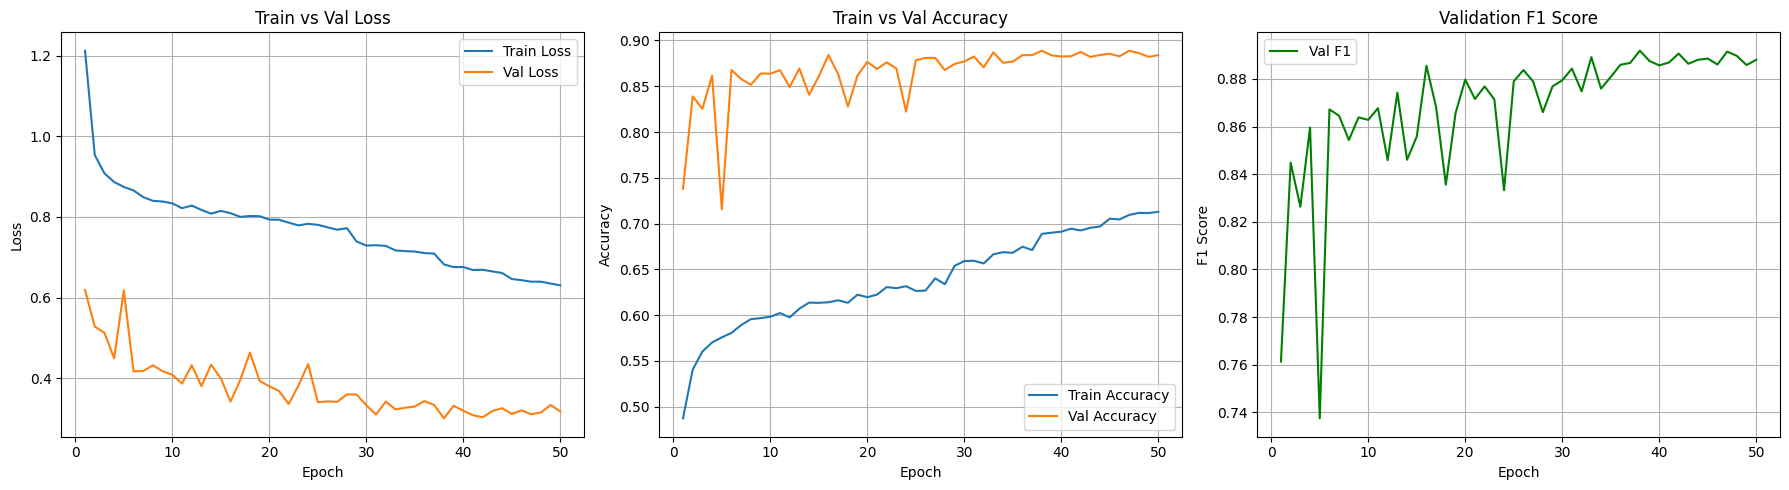


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:42<00:00, 39.64it/s]



====== Test Results ======
Overall Loss: 0.3144
Overall Accuracy: 0.8897
Cohen's Kappa: 0.8187
Per Class F1: [0.88582157 0.91131505 0.88691841]
Macro (Avg) F1: 0.8947


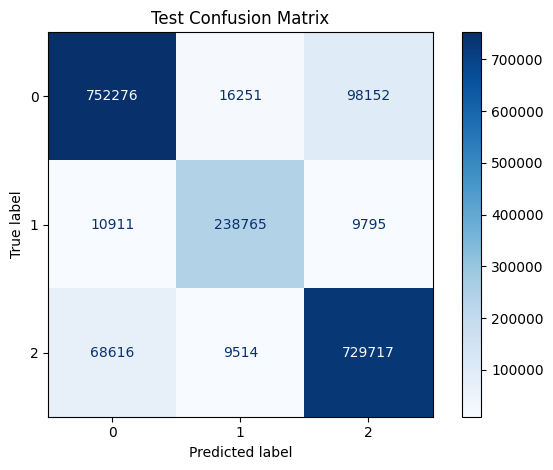

History Dumped in file /kaggle/working/true_BCNN_data_predictive_entropy_history.json_history.json


====== Loading Data /kaggle/input/data-al/true_BCNN_data_variation_ratio.npz ======
Train Data:  (14000, 28, 6) (14000,)


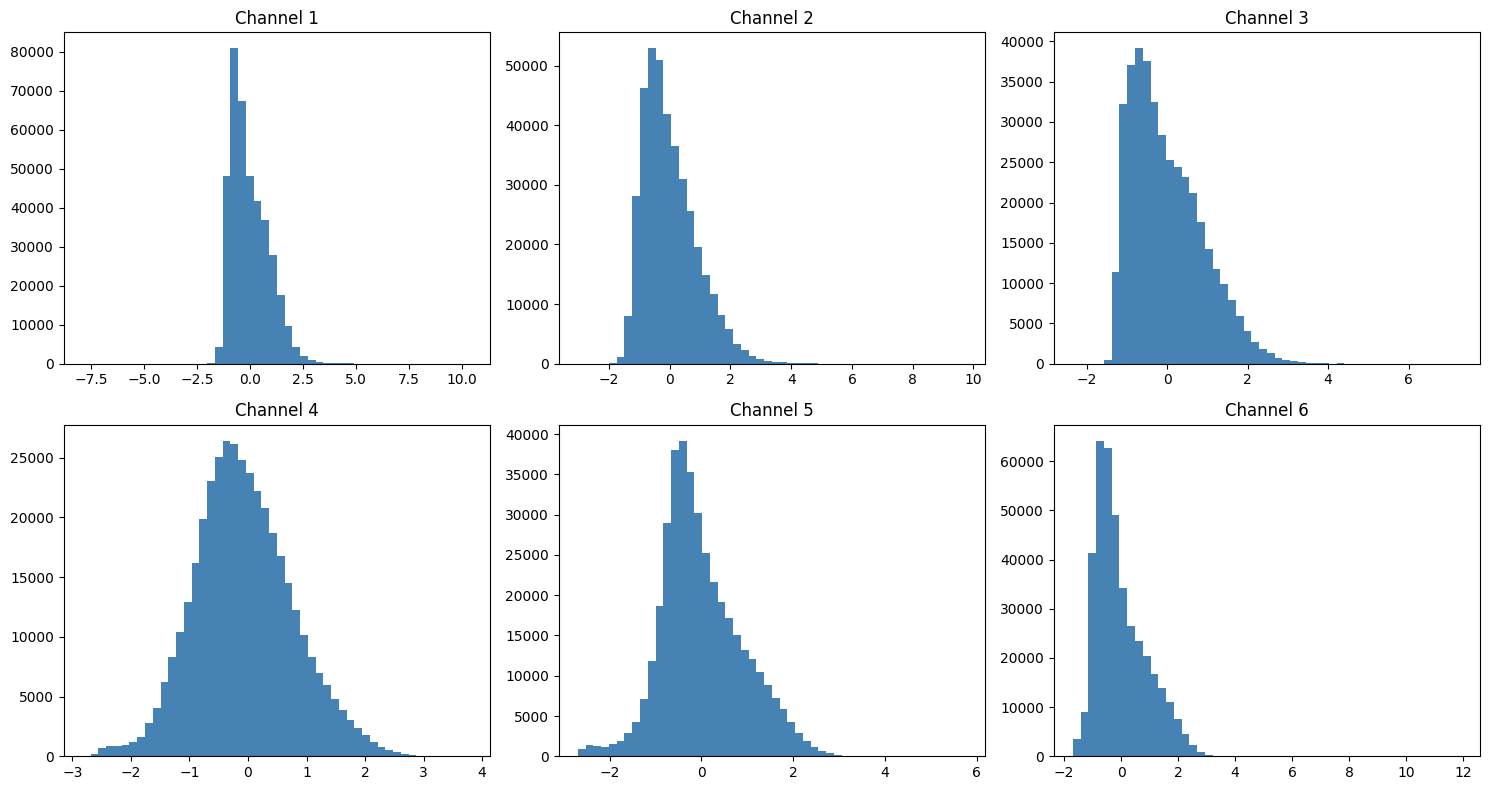

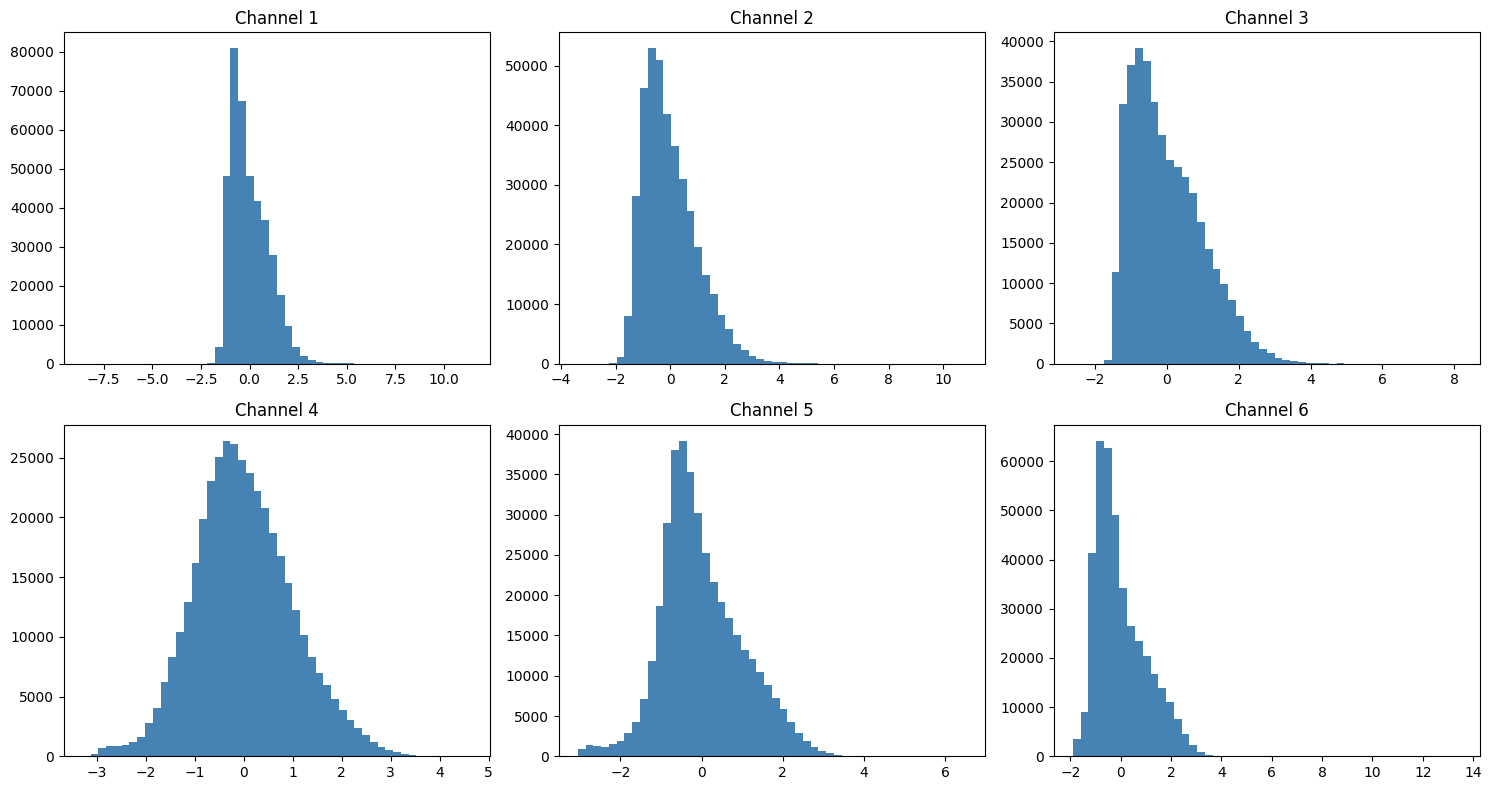



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6255      44.68%
1         1672      11.94%
2         6073      43.38%

Total samples: 14000


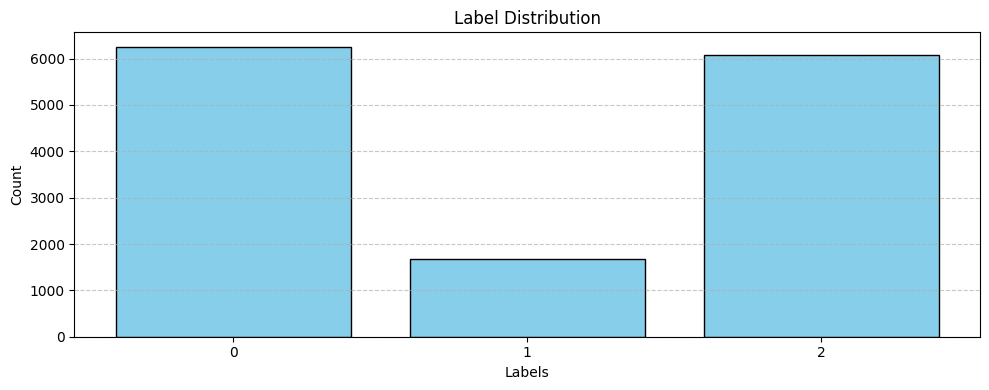


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


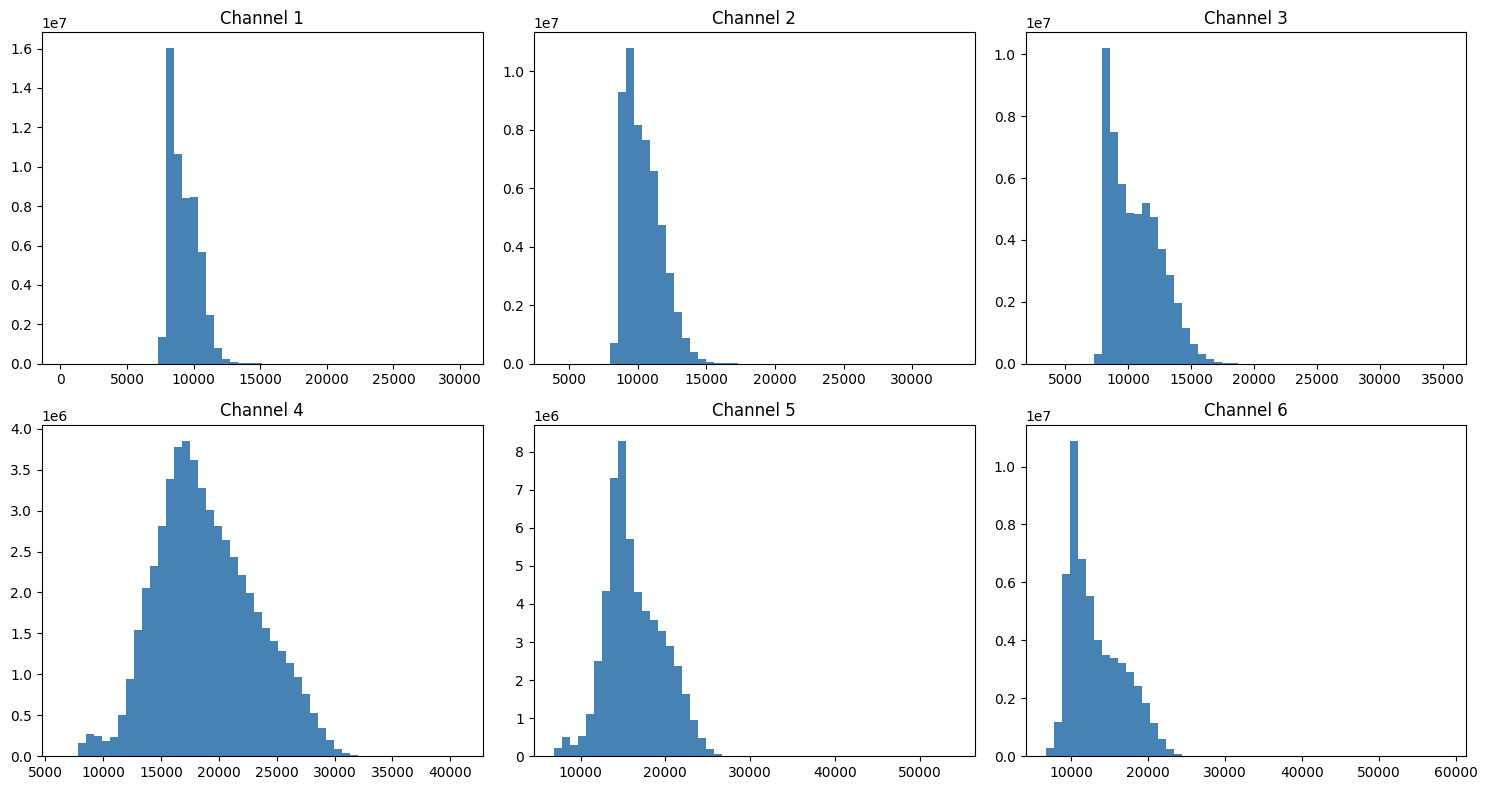

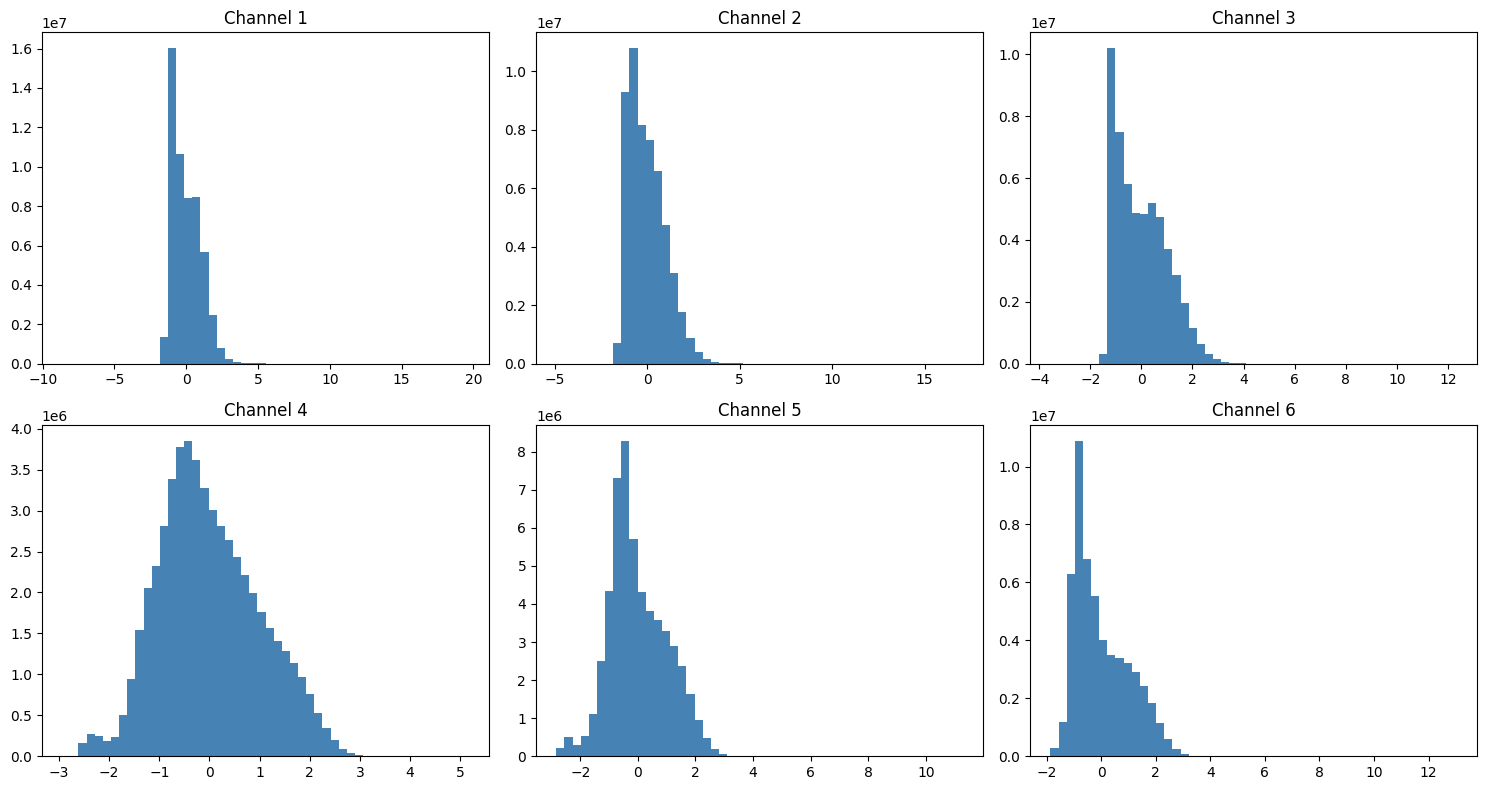



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


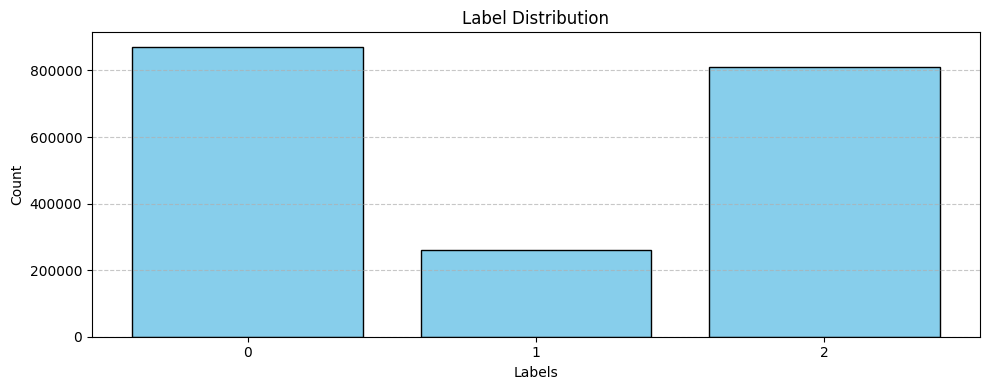

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5574, 1.3326, 0.5701], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [1/50] Train Loss: 1.1137, Train Acc: 0.5199 | Val Loss: 0.5327, Val Acc: 0.8261, F1: 0.8210, Kappa: 0.7206


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [2/50] Train Loss: 0.8523, Train Acc: 0.5689 | Val Loss: 0.4824, Val Acc: 0.8385, F1: 0.8460, Kappa: 0.7364


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [3/50] Train Loss: 0.8204, Train Acc: 0.5797 | Val Loss: 0.4595, Val Acc: 0.8667, F1: 0.8703, Kappa: 0.7814


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [4/50] Train Loss: 0.7859, Train Acc: 0.5961 | Val Loss: 0.4293, Val Acc: 0.8712, F1: 0.8723, Kappa: 0.7896


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [5/50] Train Loss: 0.7747, Train Acc: 0.5932 | Val Loss: 0.4171, Val Acc: 0.8722, F1: 0.8718, Kappa: 0.7916


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [6/50] Train Loss: 0.7537, Train Acc: 0.6069 | Val Loss: 0.4528, Val Acc: 0.8658, F1: 0.8727, Kappa: 0.7779


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [7/50] Train Loss: 0.7562, Train Acc: 0.6089 | Val Loss: 0.3794, Val Acc: 0.8798, F1: 0.8815, Kappa: 0.8030


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [8/50] Train Loss: 0.7381, Train Acc: 0.6204 | Val Loss: 0.4073, Val Acc: 0.8506, F1: 0.8568, Kappa: 0.7552


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [9/50] Train Loss: 0.7354, Train Acc: 0.6216 | Val Loss: 0.4571, Val Acc: 0.8164, F1: 0.8292, Kappa: 0.6977


Validation: 100%|██████████| 152/152 [00:03<00:00, 38.85it/s]


Epoch [10/50] Train Loss: 0.7327, Train Acc: 0.6246 | Val Loss: 0.3920, Val Acc: 0.8841, F1: 0.8879, Kappa: 0.8095


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [11/50] Train Loss: 0.7255, Train Acc: 0.6255 | Val Loss: 0.3515, Val Acc: 0.8718, F1: 0.8706, Kappa: 0.7918


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [12/50] Train Loss: 0.7236, Train Acc: 0.6296 | Val Loss: 0.3562, Val Acc: 0.8757, F1: 0.8757, Kappa: 0.7971


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [13/50] Train Loss: 0.7180, Train Acc: 0.6349 | Val Loss: 0.3807, Val Acc: 0.8746, F1: 0.8776, Kappa: 0.7942


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [14/50] Train Loss: 0.7065, Train Acc: 0.6365 | Val Loss: 0.3574, Val Acc: 0.8786, F1: 0.8798, Kappa: 0.8012


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [15/50] Train Loss: 0.7016, Train Acc: 0.6424 | Val Loss: 0.3479, Val Acc: 0.8642, F1: 0.8710, Kappa: 0.7784


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [16/50] Train Loss: 0.7085, Train Acc: 0.6353 | Val Loss: 0.3649, Val Acc: 0.8884, F1: 0.8904, Kappa: 0.8167


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [17/50] Train Loss: 0.6929, Train Acc: 0.6474 | Val Loss: 0.3252, Val Acc: 0.8885, F1: 0.8879, Kappa: 0.8178


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [18/50] Train Loss: 0.6918, Train Acc: 0.6437 | Val Loss: 0.3459, Val Acc: 0.8756, F1: 0.8714, Kappa: 0.7981


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [19/50] Train Loss: 0.6907, Train Acc: 0.6428 | Val Loss: 0.3573, Val Acc: 0.8795, F1: 0.8829, Kappa: 0.8025


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [20/50] Train Loss: 0.6819, Train Acc: 0.6516 | Val Loss: 0.3329, Val Acc: 0.8886, F1: 0.8867, Kappa: 0.8180


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [21/50] Train Loss: 0.6816, Train Acc: 0.6514 | Val Loss: 0.3295, Val Acc: 0.8963, F1: 0.8960, Kappa: 0.8294


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [22/50] Train Loss: 0.6755, Train Acc: 0.6604 | Val Loss: 0.3317, Val Acc: 0.8873, F1: 0.8875, Kappa: 0.8153


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [23/50] Train Loss: 0.6764, Train Acc: 0.6510 | Val Loss: 0.3137, Val Acc: 0.8777, F1: 0.8796, Kappa: 0.8000


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [24/50] Train Loss: 0.6688, Train Acc: 0.6588 | Val Loss: 0.3265, Val Acc: 0.8825, F1: 0.8841, Kappa: 0.8080


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [25/50] Train Loss: 0.6734, Train Acc: 0.6590 | Val Loss: 0.3322, Val Acc: 0.8865, F1: 0.8901, Kappa: 0.8136


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [26/50] Train Loss: 0.6571, Train Acc: 0.6629 | Val Loss: 0.3302, Val Acc: 0.8989, F1: 0.9018, Kappa: 0.8333


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [27/50] Train Loss: 0.6622, Train Acc: 0.6655 | Val Loss: 0.3040, Val Acc: 0.8867, F1: 0.8898, Kappa: 0.8144


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [28/50] Train Loss: 0.6573, Train Acc: 0.6676 | Val Loss: 0.3299, Val Acc: 0.8818, F1: 0.8824, Kappa: 0.8065


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [29/50] Train Loss: 0.6488, Train Acc: 0.6746 | Val Loss: 0.3265, Val Acc: 0.8852, F1: 0.8896, Kappa: 0.8113


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [30/50] Train Loss: 0.6403, Train Acc: 0.6763 | Val Loss: 0.3136, Val Acc: 0.8859, F1: 0.8827, Kappa: 0.8143


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [31/50] Train Loss: 0.6455, Train Acc: 0.6759 | Val Loss: 0.3065, Val Acc: 0.8906, F1: 0.8892, Kappa: 0.8214


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [32/50] Train Loss: 0.6355, Train Acc: 0.6807 | Val Loss: 0.3042, Val Acc: 0.8975, F1: 0.8968, Kappa: 0.8323


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [33/50] Train Loss: 0.6386, Train Acc: 0.6780 | Val Loss: 0.2934, Val Acc: 0.8967, F1: 0.8937, Kappa: 0.8312


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [34/50] Train Loss: 0.6281, Train Acc: 0.6866 | Val Loss: 0.2981, Val Acc: 0.8949, F1: 0.8928, Kappa: 0.8283


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [35/50] Train Loss: 0.6274, Train Acc: 0.6865 | Val Loss: 0.3145, Val Acc: 0.8787, F1: 0.8787, Kappa: 0.8021


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [36/50] Train Loss: 0.6202, Train Acc: 0.6877 | Val Loss: 0.2981, Val Acc: 0.9005, F1: 0.9000, Kappa: 0.8367


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.68it/s]


Epoch [37/50] Train Loss: 0.6211, Train Acc: 0.6844 | Val Loss: 0.2977, Val Acc: 0.8830, F1: 0.8828, Kappa: 0.8090


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.65it/s]


Epoch [38/50] Train Loss: 0.6169, Train Acc: 0.6919 | Val Loss: 0.3392, Val Acc: 0.8796, F1: 0.8832, Kappa: 0.8025


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [39/50] Train Loss: 0.6058, Train Acc: 0.6974 | Val Loss: 0.3146, Val Acc: 0.8896, F1: 0.8880, Kappa: 0.8199


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.63it/s]


Epoch [40/50] Train Loss: 0.5761, Train Acc: 0.7171 | Val Loss: 0.3108, Val Acc: 0.8973, F1: 0.8978, Kappa: 0.8315


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [41/50] Train Loss: 0.5601, Train Acc: 0.7224 | Val Loss: 0.2762, Val Acc: 0.9053, F1: 0.9050, Kappa: 0.8448


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [42/50] Train Loss: 0.5620, Train Acc: 0.7251 | Val Loss: 0.2858, Val Acc: 0.9003, F1: 0.9022, Kappa: 0.8362


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [43/50] Train Loss: 0.5554, Train Acc: 0.7290 | Val Loss: 0.2883, Val Acc: 0.8974, F1: 0.8980, Kappa: 0.8319


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [44/50] Train Loss: 0.5514, Train Acc: 0.7306 | Val Loss: 0.2857, Val Acc: 0.9054, F1: 0.9056, Kappa: 0.8448


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [45/50] Train Loss: 0.5504, Train Acc: 0.7319 | Val Loss: 0.2821, Val Acc: 0.9032, F1: 0.9041, Kappa: 0.8409


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [46/50] Train Loss: 0.5409, Train Acc: 0.7303 | Val Loss: 0.2822, Val Acc: 0.9064, F1: 0.9067, Kappa: 0.8461


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [47/50] Train Loss: 0.5427, Train Acc: 0.7326 | Val Loss: 0.2868, Val Acc: 0.9009, F1: 0.9012, Kappa: 0.8376


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [48/50] Train Loss: 0.5185, Train Acc: 0.7406 | Val Loss: 0.2786, Val Acc: 0.9087, F1: 0.9089, Kappa: 0.8501


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [49/50] Train Loss: 0.5099, Train Acc: 0.7501 | Val Loss: 0.2818, Val Acc: 0.9081, F1: 0.9092, Kappa: 0.8490


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [50/50] Train Loss: 0.5040, Train Acc: 0.7552 | Val Loss: 0.2770, Val Acc: 0.9069, F1: 0.9089, Kappa: 0.8469


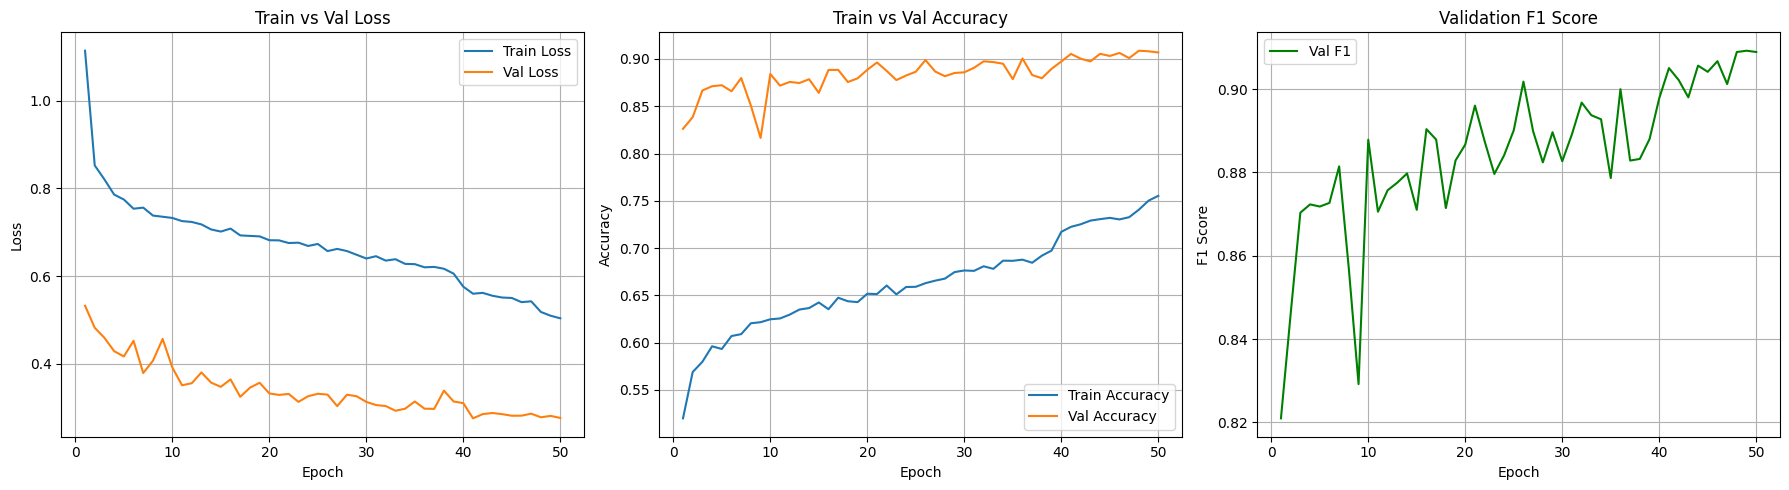


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:40<00:00, 39.74it/s]



====== Test Results ======
Overall Loss: 0.2787
Overall Accuracy: 0.9077
Cohen's Kappa: 0.8481
Per Class F1: [0.90722753 0.91787493 0.90502491]
Macro (Avg) F1: 0.9100


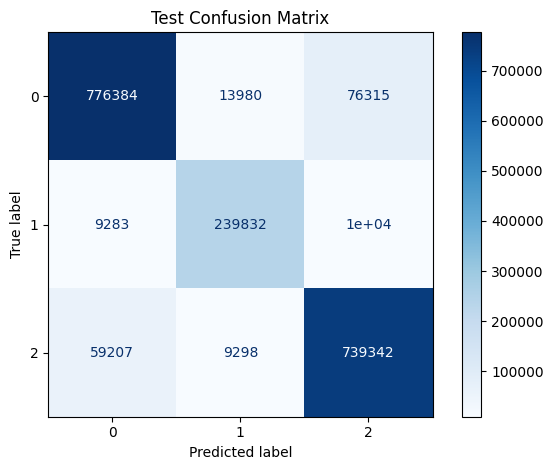

History Dumped in file /kaggle/working/true_BCNN_data_variation_ratio_history.json_history.json
Saved history of all files to approx_BCNN_training_evaluation.xlsx


In [18]:
for name in file_names:
    print(f'\n\n====== Loading Data {name} ======')
    X_train, y_train = load_data(name)
    
    if X_train.shape[1:] == (6,28):
        X_train = X_train.transpose(0,2,1)
    
    print('Train Data: ', X_train.shape, y_train.shape)
    plot_input_dist(X_train)
    X_train = normalize(X_train)
    plot_input_dist(X_train)
    plot_label_dist(y_train)

    print(f'\n====== Loading Data Site {SITE} - {YEAR} ======')
    X_B2020, y_B2020 = load_data(X_B2020_path, y_B2020_path)
    print(f'Site {SITE} - {YEAR} Data: {X_B2020.shape}, {y_B2020.shape}')
    plot_input_dist(X_B2020)
    X_B2020 = normalize(X_B2020)
    plot_input_dist(X_B2020)
    plot_label_dist(y_B2020)

    # Data Split
    X_test, X_val, y_test, y_val = train_test_split(X_B2020, y_B2020, test_size=0.005, stratify=y_B2020, random_state=42)
    print(f'Val Data: ', X_val.shape, y_val.shape)
    print(f'Test Data: ', X_test.shape, y_test.shape)

    # Creating datasets and dataloaders
    train_dataset = Conv1dDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = Conv1dDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = Conv1dDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model Initialization
    backbone = cnn_dropout().to(DEVICE)
    fc = FC_dropout(1024).to(DEVICE)
    backbone.load_state_dict(backbone_state)
    fc.load_state_dict(fc_state)

    # ===== Class weights =====
    all_labels = np.array(y_train)  # shape: (num_samples, H, W) if segmentation

    # Flatten labels and count occurrences
    flattened = all_labels.flatten()
    flattened = flattened[flattened >= 0]
    class_counts = np.bincount(flattened, minlength=NUM_CLASSES)
    total_pixels = class_counts.sum()
    
    # Inverse frequency (optionally normalize)
    class_weights = total_pixels / (NUM_CLASSES * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    class_weights = torch.log(1 + class_weights)
    print(class_weights)

    print(f'\n====== Training the Model ======')
    train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s = train(backbone, fc, train_dataloader, val_dataloader, DEVICE, class_weights=class_weights, epochs=EPOCHS, T=T)
    plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS)

    print(f'\n====== Testing the Model ======')
    loss, acc, avg_f1, per_class_f1, kappa, cm = mc_dropout_eval(backbone, fc, test_dataloader, class_weights=class_weights, T=T)

    # Printing
    print(f'\n====== Test Results ======')
    print(f'Overall Loss: {loss:.4f}')
    print(f'Overall Accuracy: {acc:.4f}')
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f'Per Class F1: {per_class_f1}')
    print(f"Macro (Avg) F1: {avg_f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Test Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Logging History
    history[name]['train_loss'] = train_losses
    history[name]['train_acc'] = train_accs
    history[name]['val_loss'] = val_losses
    history[name]['val_acc'] = val_accs
    history[name]['val_f1s'] = val_f1s
    history[name]['val_kappas'] = val_kappas
    history[name]['val_per_class_f1s'] = val_per_class_f1s
    
    history[name]['overall_loss'] = float(loss)
    history[name]['overall_acc'] = float(acc)
    history[name]['kappa'] = float(kappa)
    history[name]['per_class_f1'] = per_class_f1.tolist() if isinstance(per_class_f1, (np.ndarray, list)) else per_class_f1
    history[name]['avg_f1'] = float(avg_f1)
    history[name]['cm'] = cm.tolist() if hasattr(cm, "tolist") else cm

    # Dumping History
    save_history(history[name], f"{name}_history.json")

    
# Saving the Results
save_results('approx_BCNN_training_evaluation', history)

<hr>